# Stock Price Prediction - Petrobras S.A.

The aim of this project is to build machine learning models in order to predict future stock prices for the brazilian company Petrobras S.A. For this, we use three tree-based machine learning models: regression trees, random forest and XGBoost.

Authors: 

*Caio Lopes de Souza* 

*Gabriel Rodrigues Palma*

*Silvio Sandoval Zocchi*

## Libraries and Packages

In [1]:
# data extraction 
import yfinance as yfin
from pandas_datareader import data as pdr
from yahooquery import Ticker 

# statistical analysis and modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# data manipulation 
import numpy as np
import pandas as pd
import datetime as dt

# data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 

# machine learning models
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

# models performance metrics
from sklearn.metrics import mean_squared_error

# preprocessing
from sklearn.preprocessing import StandardScaler

## Functions

In [2]:
def open_data(path):
    '''read a csv file and returns a dataframe'''
    
    dataframe = pd.read_csv(path, encoding='latin-1')
    
    return dataframe

In [3]:
def correct_data(dataframe, old_column, new_columns, split_point):
    '''correct data formatting'''
    
    dataframe[new_columns] = dataframe[old_column].str.split(split_point, expand=True)
    dataframe = dataframe.drop(old_column, axis=1)
    
    return dataframe

In [4]:
def correct_multindex(data, level, column_exclusion): 
    '''transform a multindex dataframe into a dataframe with only one index'''
    
    data = data.reset_index(level=level)
    data = data.drop(column_exclusion, axis=1)
    
    return data

In [5]:
def convert_datatypes(dataframe, column_to_numeric, column_to_date):
    '''change the datatype of two columns from object to numeric and date'''

    dataframe[column_to_numeric] = pd.to_numeric(dataframe[column_to_numeric])
    dataframe[column_to_date] = pd.to_datetime(dataframe[column_to_date], format='%d/%m/%Y')
    
    return dataframe

In [6]:
def line_plot(dataset, column_list, x_label, y_label, title):
    '''plot a standardized line plot for a chosen variable from a dataset'''
    color_list = ['blue', 'red', 'green']
    
    fig, ax = plt.subplots(figsize=(8, 3))
    for column in column_list: 
        dataset[column].plot(color=color_list[column_list.index(column)], ax=ax)
            
        ax.set_label(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
            
        plt.tight_layout()

In [7]:
def plot_test_error(y, predictions, model):
    '''plot the the real value of the response variable and its predictions by the model'''
    predictions = pd.Series(predictions)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    predictions.plot(ax=ax)
    
    y.plot(ax=ax)
    
    ax.legend(['Predictions', 'Actual Value'])
    
    ax.set_title(f"Comparison between the actual value of the response variable and its correspondent prediction for the {model}",)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Value/Prediction')

    plt.tight_layout()

In [8]:
def training_test_split(X, y, starting_point = 0.8):
    '''split a dataset into a training and test set for a chosen ratio'''
    X_train = X.iloc[:round(starting_point * len(X))]
    X_test = X.iloc[round(starting_point * len(X)):]
    y_train = y.iloc[:round(starting_point * len(y))]
    y_test = y.iloc[round(starting_point * len(y)):]
    
    return X_train, X_test, y_train, y_test

In [14]:
def one_step_ahead_forecasting(X, y, model, starting_point):
    '''predict the next observation of a time series using as training set all the past observations'''
    
    predictions = np.array([])
    print('Treinando')
    X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point = starting_point)
    print('Fit')
    model.fit(X_train.values, y_train.values)
    print('Fit final')
    for i in range(len(X_test)):
        predictions = np.append(predictions, (model.predict(X_test.iloc[i].values.reshape(1, -1))))
        print('Predição')
        X_train = pd.concat([X_train, X_test.iloc[i].to_frame().T])
        y_train = np.append(y_train, y_test.iloc[i].reshape(1, -1))
        
        y_train = pd.Series(y_train)
        
        model.fit(X_train.values, y_train.values)
        
    return predictions

In [15]:
def one_step_ahead_forecasting_univariate(X, y, model, starting_point):
    '''predict the next observation of a time series using as training set all the past observations'''
    
    predictions = np.array([])
    print('Treinando')
    X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point = starting_point)
    print('Fit')
    model.fit(X_train.values.reshape(-1, 1), y_train.values)
    print('Fit final')
    for i in range(len(X_test)):
        predictions = np.append(predictions, (model.predict(X_test.iloc[i].reshape(1, -1))))
        print('Predição')
        X_train = np.append(X_train, X_test.iloc[i])
        y_train = np.append(y_train, y_test.iloc[i].reshape(1, -1))
        
        y_train = pd.Series(y_train)
        
        model.fit(X_train.reshape(-1, 1), y_train.values)
        
    return predictions

In [16]:
def residual_plot(predictions, y_test):
    residual = predictions - y_test

    fig, ax = plt.subplots(figsize=(10,6))
    
    residual.plot(ax=ax)

In [17]:
def residual_log_plot(predictions, y_test): 
    residual = np.log(predictions) - np.log(y_test)

    fig, ax = plt.subplots(figsize=(10,6))

    residual.plot(ax=ax)

## Data gathering and manipulation

In [18]:
start = '2001-12-31'
end = '2023-12-31'

### Exchange rate

In [19]:
exchange_rate = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/Câmbio_diário(1984-2023)_v2.csv")

In [20]:
exchange_rate

Data;Cambio
0     02/01/1990;11.524
1     03/01/1990;11.751
2     04/01/1990;11.983
3     05/01/1990;12.209
4      08/01/1990;12.44
...                 ...
8392   26/06/2023;4.769
8393    27/06/2023;4.79
8394   28/06/2023;4.856
8395   29/06/2023;4.858
8396   30/06/2023;4.819

[8397 rows x 1 columns]

In [21]:
exchange_rate = correct_data(exchange_rate, 'Data;Cambio', ['Date', 'Exchange_rate'], ';')
exchange_rate = convert_datatypes(exchange_rate, column_to_numeric = 'Exchange_rate', column_to_date = 'Date')

In [22]:
exchange_rate = exchange_rate.loc[exchange_rate['Date'] >= start]

In [23]:
exchange_rate.head()

Date  Exchange_rate
2995 2001-12-31          2.320
2996 2002-01-02          2.306
2997 2002-01-03          2.292
2998 2002-01-04          2.309
2999 2002-01-07          2.342

### SELIC

In [24]:
selic = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/SELIC(2000-2023).csv")

In [25]:
selic = correct_data(selic, 'Data;Selic', ['Date', 'Selic'], ';')
selic = convert_datatypes(selic, column_to_numeric = 'Selic', column_to_date = 'Date')

In [26]:
selic = selic.loc[selic['Date'] >= start]

In [27]:
selic.head()

Date  Selic
730 2001-12-31   19.0
731 2002-01-01   19.0
732 2002-01-02   19.0
733 2002-01-03   19.0
734 2002-01-04   19.0

### Oil price

In [28]:
oil = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/petróleo_preço(1987-2023).csv")

In [29]:
oil = correct_data(oil, 'Data;Preço do petróleo brent(dólares/barril)', ['Date', 'Oil_price'], ';')
oil = convert_datatypes(oil, column_to_numeric = 'Oil_price', column_to_date = 'Date')

In [30]:
oil = oil.loc[oil['Date'] >= start]

In [31]:
oil.head()

Date  Oil_price
3709 2001-12-31      19.35
3710 2002-01-02      20.13
3711 2002-01-03      20.47
3712 2002-01-04      21.20
3713 2002-01-07      21.08

### Stock price

In [45]:
stock = Ticker("PETR4.SA")
stock_price = stock.history(start = start, end = end)
stock_price = stock_price['adjclose']
stock_price = pd.DataFrame(stock_price, columns =['adjclose'])

#### Data manipulation

In [46]:
stock_price = correct_multindex(stock_price, level=[0, 1], column_exclusion = 'symbol')
stock_price = convert_datatypes(stock_price, column_to_numeric = 'adjclose', column_to_date='date')
stock_price = stock_price.rename(columns={"date": "Date", "adjclose": "Close_price"})

In [47]:
stock_price.to_csv('petrobras_daily_price.csv', index = False)

In [48]:
stock_price

Date  Close_price
0    2001-12-31     1.578670
1    2002-01-01     1.578670
2    2002-01-02     1.581756
3    2002-01-03     1.592559
4    2002-01-04     1.582682
...         ...          ...
5501 2023-12-21    36.389999
5502 2023-12-22    36.740002
5503 2023-12-26    37.330002
5504 2023-12-27    37.360001
5505 2023-12-28    37.240002

[5506 rows x 2 columns]

### Merging all together

In [436]:
data_list = [stock_price, exchange_rate, selic, oil]

dataset = stock_price.merge(exchange_rate, on='Date')
dataset = dataset.merge(selic, on='Date')
dataset = dataset.merge(oil, on='Date')

dataset.index = dataset['Date']

dataset = dataset.drop('Date', axis=1)

In [437]:
data_list = [stock_price, exchange_rate, selic, oil]

In [438]:
dataset = stock_price.merge(exchange_rate, on='Date')
dataset = dataset.merge(selic, on='Date')
dataset = dataset.merge(oil, on='Date')

In [439]:
dataset.index = dataset['Date']

dataset = dataset.drop('Date', axis=1)

In [440]:
dataset

Close_price  Exchange_rate  Selic  Oil_price
Date                                                    
2001-12-31     1.578670          2.320  19.00      19.35
2002-01-02     1.581756          2.306  19.00      20.13
2002-01-03     1.592558          2.292  19.00      20.47
2002-01-04     1.582682          2.309  19.00      21.20
2002-01-07     1.617250          2.342  19.00      21.08
...                 ...            ...    ...        ...
2023-06-20    28.357922          4.792  13.75      75.79
2023-06-21    29.545300          4.779  13.75      76.92
2023-06-22    29.174242          4.774  13.75      73.93
2023-06-23    27.977589          4.779  13.75      73.56
2023-06-26    28.608383          4.769  13.75      73.86

[5239 rows x 4 columns]

## Training test split
The training test split to be considered is a 60/40, i.e., 60% of the dataset for training and the remaining 40% for test.

In [441]:
y = dataset['Close_price']
X = dataset.drop('Close_price', axis = 1)

In [442]:
X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point=0.6)

### The naive model (random walk)


For a naive model, which will be used to compare the performance of the other models, we'll consider the value of the estimate for the response variable as being equal to the value of the response variable in the past day. In other words,  $\hat{y}_{t+1} = y_{t}$

In [443]:
naive_predictions = y_test.shift(1)

In [444]:
y_test.index[0]

Timestamp('2014-11-14 00:00:00')

In [445]:
drop = y_test.drop(y_test.index[0])

In [446]:
mean_squared_error(y_test.drop(y_test.index[0]), naive_predictions.dropna())

0.07683783386361122

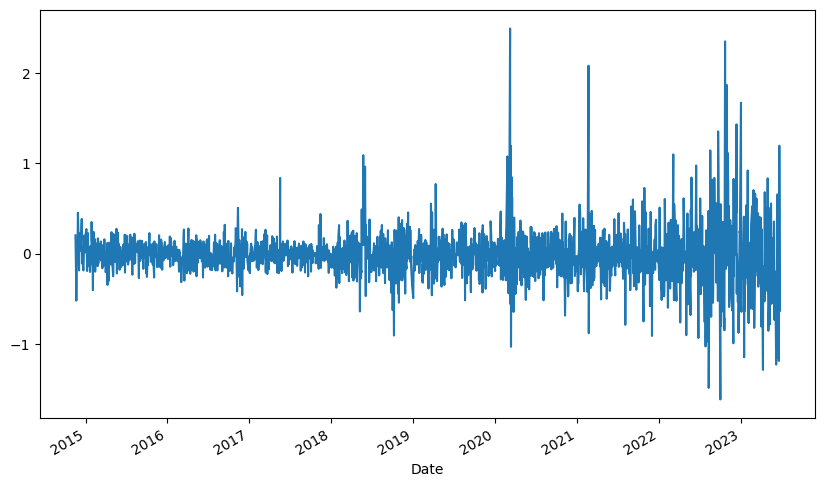

In [447]:
residual_plot(naive_predictions, y_test)

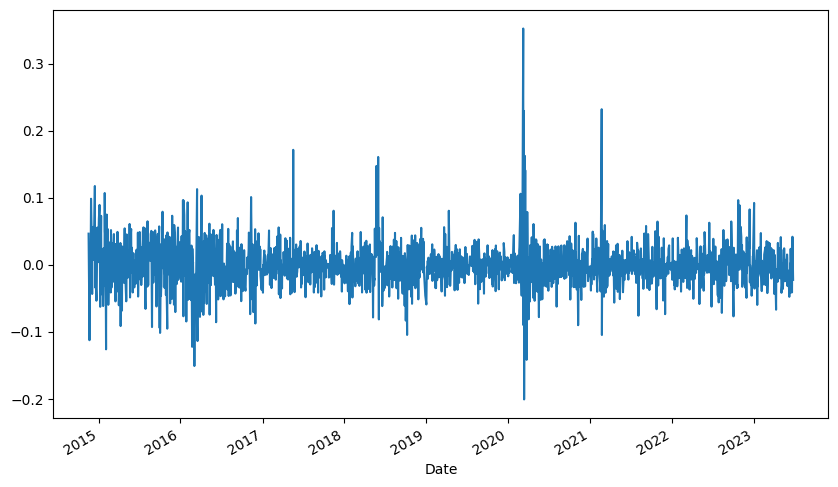

In [448]:
residual_log_plot(naive_predictions, y_test)

## Machine learning models

Three machine learning models will be estimated: a regression tree, a random forest and a XGBoost.

### Only exogenous explanatory variables without lag

Here, we consider a regression tree, a random forest and a XGBoost where the explanatory variables are the three exonegous variables (interest rate, exchange rate and oil price) without considering any kind of lag. Moreover, we consider the actual value for all the variables, not using the residual value as we are going to use later.



### Regression Tree

#### Creating the model

In [134]:
reg_tree = DecisionTreeRegressor(random_state=42)

#### Predictions

In [135]:
tree_predictions = one_step_ahead_forecasting(X = X, y = y, model = reg_tree ,starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [136]:
tree_predictions = pd.Series(tree_predictions, index = y_test.index)

#### Results

In [137]:
print(f"The MSE for the model is {mean_squared_error(y_test, tree_predictions)}")

The MSE for the model is 0.5672049419088258


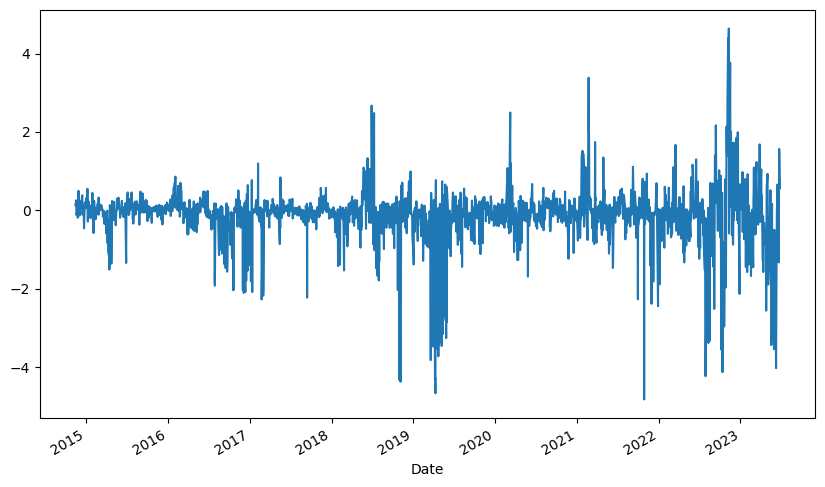

In [138]:
residual_plot(tree_predictions, y_test)

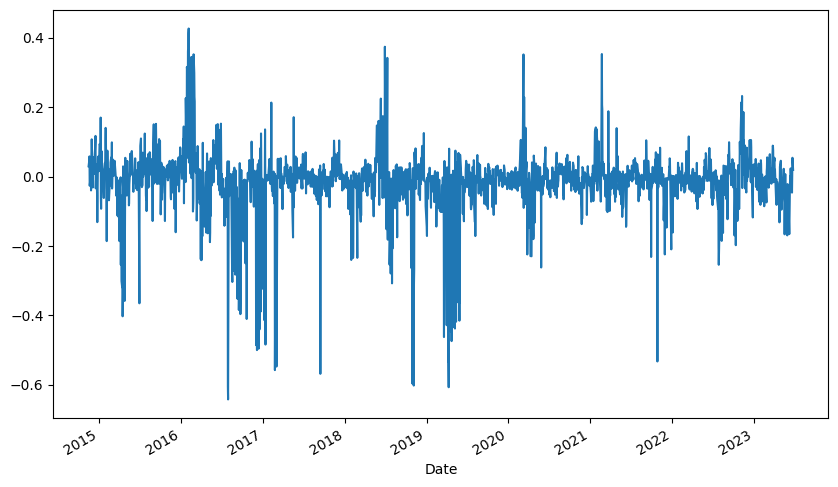

In [139]:
residual_log_plot(tree_predictions, y_test)

### Random Forest

#### Creating the model

In [140]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state=42)

#### Predictions

In [141]:
rf_predictions = one_step_ahead_forecasting(X = X, y = y, model = rf_reg, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [142]:
rf_predictions = pd.Series(rf_predictions, index = y_test.index)

#### Results

In [143]:
print(f"The MSE for the model is {mean_squared_error(y_test, rf_predictions)}")

The MSE for the model is 0.4997380477252694


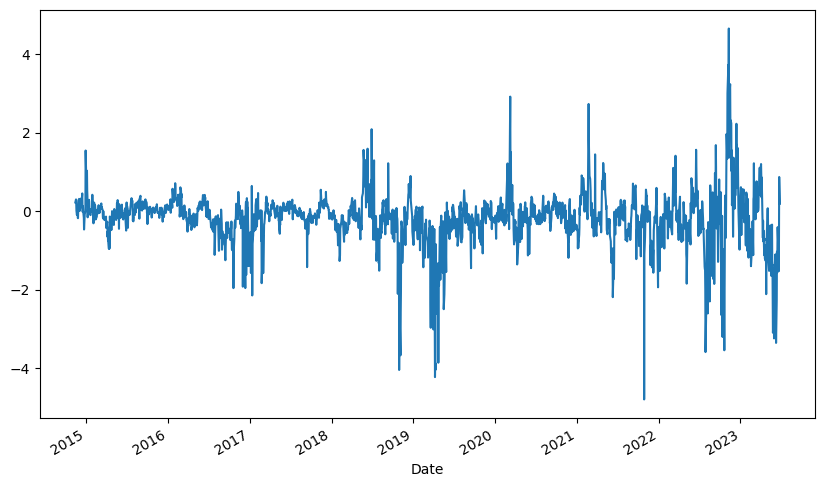

In [144]:
residual_plot(rf_predictions, y_test)

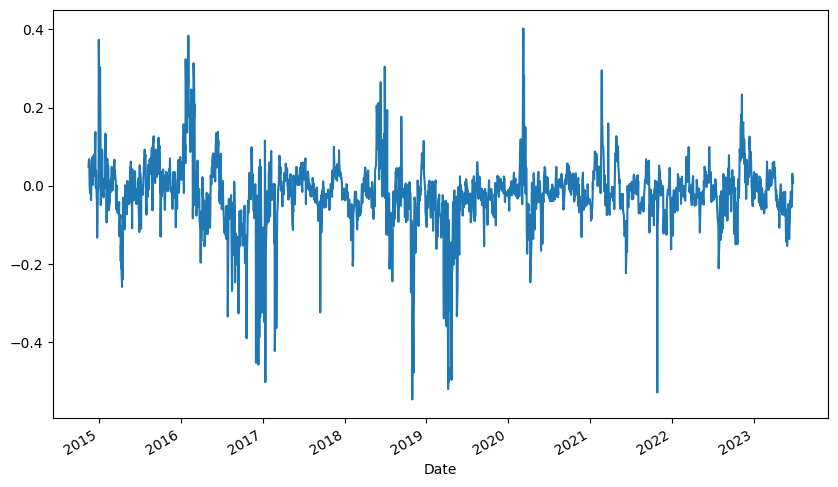

In [145]:
residual_log_plot(rf_predictions, y_test)

### XGBoost

#### Creating the model

In [146]:
xgb = XGBRegressor()

#### Predictions

In [147]:
xgb_predictions = one_step_ahead_forecasting(X = X, y = y, model = xgb, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [148]:
xgb_predictions = pd.Series(xgb_predictions, index=y_test.index)

#### Results

In [149]:
mean_squared_error(y_test, xgb_predictions)

0.5367160694107935

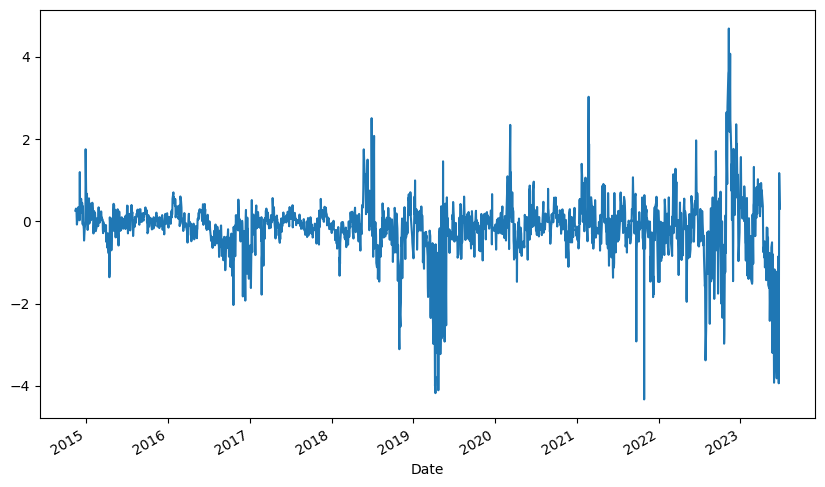

In [150]:
residual_plot(xgb_predictions, y_test)

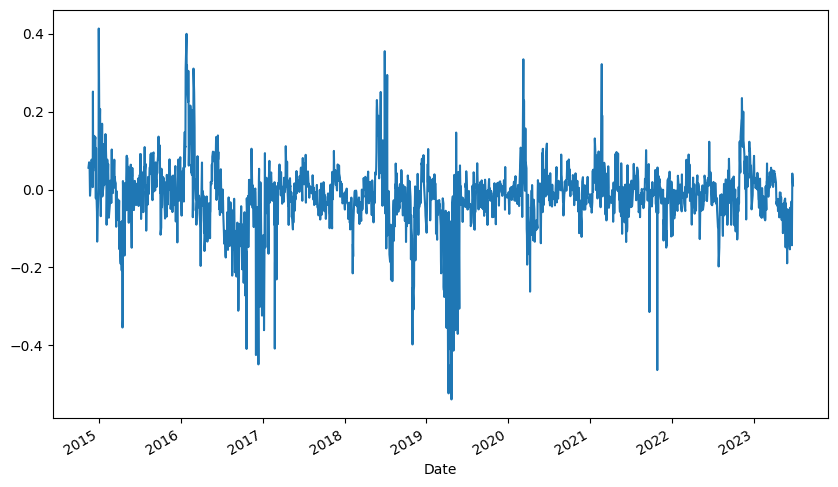

In [151]:
residual_log_plot(xgb_predictions, y_test)

### Adding lags

We'll add lags for the response variable that ranges 1 to 10 days

In [152]:
for i in range(1, 11):
    dataset[f"price_lag_{i}"] = dataset['Close_price'].shift(i)
dataset = dataset.dropna(axis=0)

In [153]:
dataset.head()

Close_price  Exchange_rate  Selic  Oil_price  price_lag_1  \
Date                                                                    
2002-01-15     1.490092          2.370   19.0      18.86     1.493796   
2002-01-16     1.483302          2.386   19.0      18.50     1.490092   
2002-01-17     1.510770          2.363   19.0      18.20     1.483302   
2002-01-18     1.510153          2.374   19.0      18.17     1.510770   
2002-01-21     1.496881          2.373   19.0      18.32     1.510153   

            price_lag_2  price_lag_3  price_lag_4  price_lag_5  price_lag_6  \
Date                                                                          
2002-01-15     1.549350     1.567867     1.580213     1.597188     1.617249   
2002-01-16     1.493796     1.549350     1.567867     1.580213     1.597188   
2002-01-17     1.490092     1.493796     1.549350     1.567867     1.580213   
2002-01-18     1.483302     1.490092     1.493796     1.549350     1.567867   
2002-01-21     1.510770     1.483302     1.490092     1.493796     1.549350   

            price_lag_7  price_lag_8  price_lag_9  price_lag_10  
Date                                                             
2002-01-15     1.582682     1.592558     1.581756      1.578669  
2002-01-16     1.617249     1.582682     1.592558      1.581756  
2002-01-17     1.597188     1.617249     1.582682      1.592558  
2002-01-18     1.580213     1.597188     1.617249      1.582682  
2002-01-21     1.567867     1.580213     1.597188      1.617249

In [154]:
y = dataset['Close_price']
X = dataset.drop('Close_price', axis=1)

In [155]:
X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point=0.6)

#### Dataset with lags only

In [156]:
X_only_lag = X.drop(['Exchange_rate', 'Selic', 'Oil_price'], axis=1)

### Regression tree with lags

#### Predictions

In [157]:
tree_lag_predictions = one_step_ahead_forecasting(X = X, y = y, model = reg_tree ,starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [158]:
tree_lag_predictions = pd.Series(tree_lag_predictions, index = y_test.index)

#### Results

In [159]:
mean_squared_error(y_test, tree_lag_predictions)

0.173661244453701

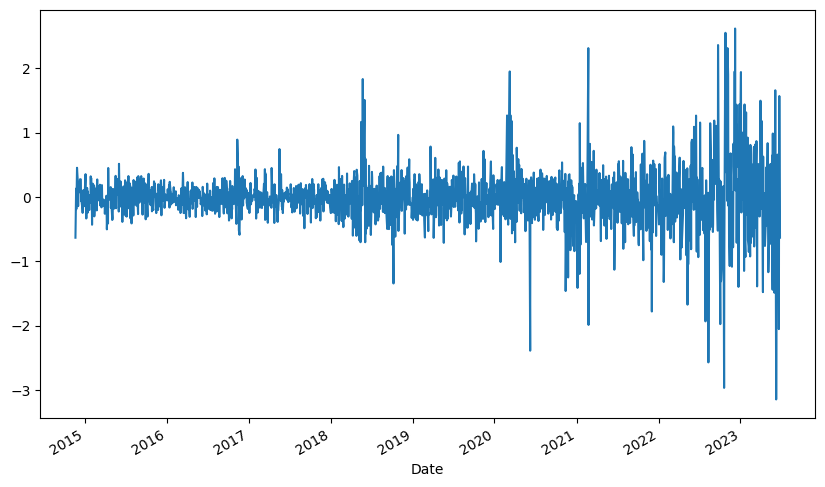

In [160]:
residual_plot(tree_lag_predictions, y_test)

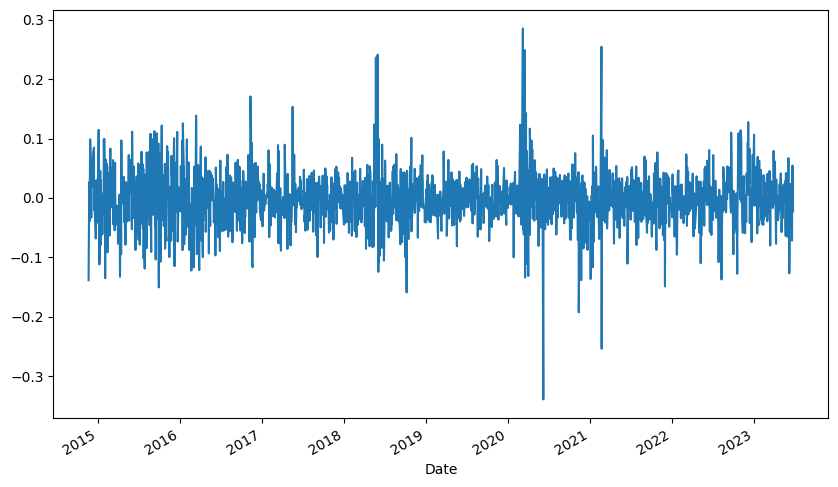

In [161]:
residual_log_plot(tree_lag_predictions, y_test)

### Regression tree only lags

#### Predictions

In [162]:
tree_only_lag_predictions = one_step_ahead_forecasting(X = X_only_lag, y = y,
                                                       model = reg_tree, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [163]:
tree_only_lag_predictions = pd.Series(tree_only_lag_predictions, index = y_test.index)

#### Results

In [164]:
mean_squared_error(y_test, tree_only_lag_predictions)

0.173489335923787

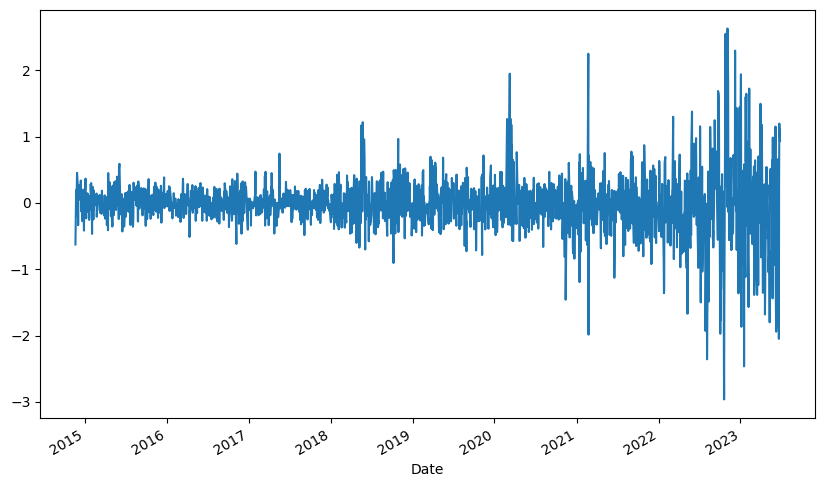

In [165]:
residual_plot(tree_only_lag_predictions, y_test)

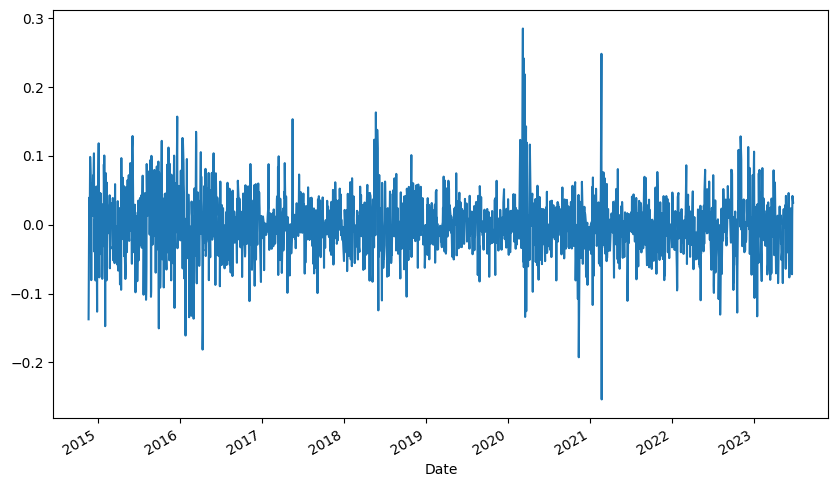

In [166]:
residual_log_plot(tree_only_lag_predictions, y_test)

### Only one lag for the response variable

In [450]:
X_only_one_lag = y.shift(1)

In [451]:
X_only_one_lag = X_only_one_lag.dropna() 

In [452]:
X_only_one_lag

Date
2002-01-02     1.578670
2002-01-03     1.581756
2002-01-04     1.592558
2002-01-07     1.582682
2002-01-08     1.617250
                ...    
2023-06-20    28.218777
2023-06-21    28.357922
2023-06-22    29.545300
2023-06-23    29.174242
2023-06-26    27.977589
Name: Close_price, Length: 5238, dtype: float64

In [453]:
y.drop(y.index[0])

Date
2002-01-02     1.581756
2002-01-03     1.592558
2002-01-04     1.582682
2002-01-07     1.617250
2002-01-08     1.597188
                ...    
2023-06-20    28.357922
2023-06-21    29.545300
2023-06-22    29.174242
2023-06-23    27.977589
2023-06-26    28.608383
Name: Close_price, Length: 5238, dtype: float64

### Regression tree only one lag

In [454]:
tree_only_one_lag_predictions = one_step_ahead_forecasting_univariate(X = X_only_one_lag, y = y.drop(y.index[0]),
                                                       model = reg_tree, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [455]:
tree_only_one_lag_predictions = pd.Series(tree_only_one_lag_predictions, index = y_test.drop(y_test.index[0]).index)

In [456]:
len(tree_only_one_lag_predictions)

2095

In [411]:
len(y_test)

2087

#### Results

In [457]:
mean_squared_error(y_test.drop(y_test.index[0]), tree_only_one_lag_predictions)

0.1489757669475181

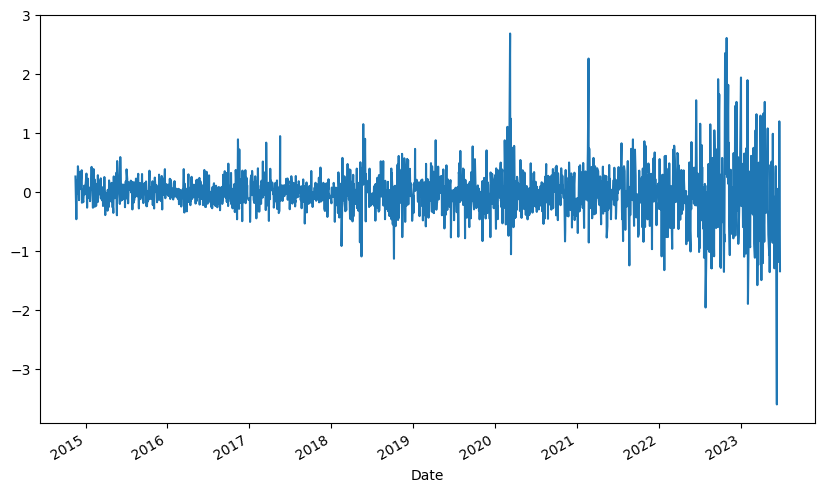

In [460]:
residual_plot(tree_only_one_lag_predictions, y_test)

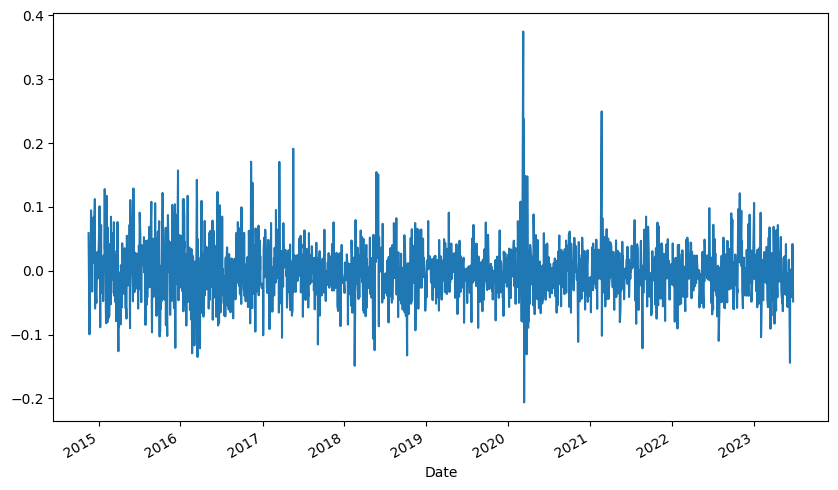

In [461]:
residual_log_plot(tree_only_one_lag_predictions, y_test)

### Random forest with lags

#### Predictions

In [171]:
rf_lag_predictions = one_step_ahead_forecasting(X = X, y = y, model = rf_reg, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
P

In [172]:
rf_lag_predictions = pd.Series(rf_lag_predictions, index = y_test.index)

#### Results

In [173]:
mean_squared_error(y_test, rf_lag_predictions)

0.10311935470978514

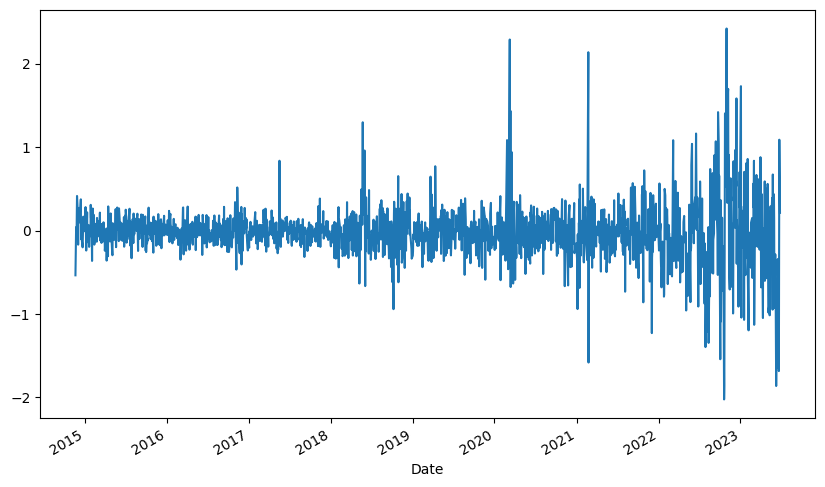

In [174]:
residual_plot(rf_lag_predictions, y_test)

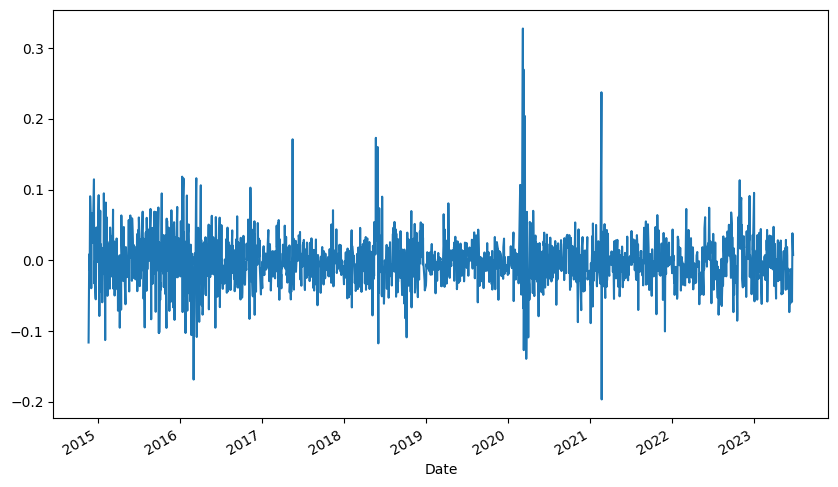

In [175]:
residual_log_plot(rf_lag_predictions, y_test)

### Random forest with only lags

#### Predictions

In [176]:
rf_only_lag_predictions = one_step_ahead_forecasting(X = X_only_lag, y = y,
                                                     model = rf_reg, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [177]:
rf_only_lag_predictions = pd.Series(rf_only_lag_predictions, index = y_test.index)

#### Results

In [178]:
mean_squared_error(y_test, rf_only_lag_predictions)

0.10518672153019465

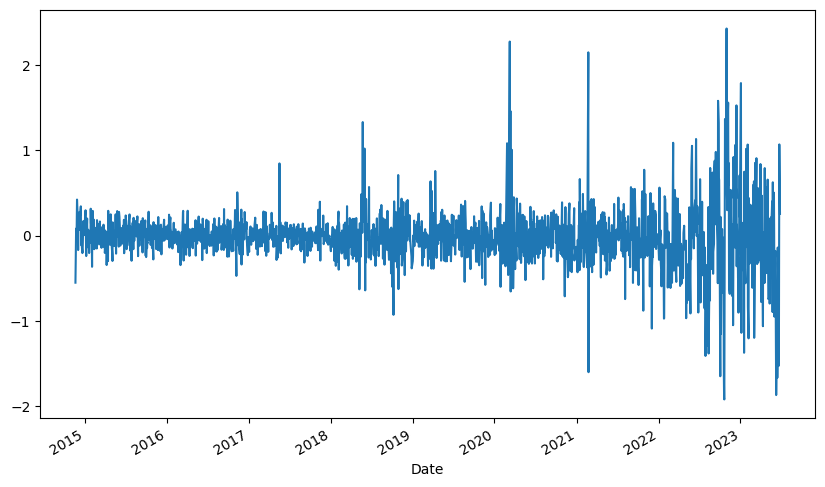

In [179]:
residual_plot(rf_only_lag_predictions, y_test)

In [ ]:
residual_log_plot(rf_only_lag_predictions, y_test)

### Random forest with only one lag

#### Predictions

In [462]:
rf_only_one_lag_predictions = one_step_ahead_forecasting_univariate(X = X_only_one_lag, y = y,
                                                     model = rf_reg, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [ ]:
len(rf_only_one_lag_predictions)

In [ ]:
rf_only_one_lag_predictions = pd.Series(rf_only_one_lag_predictions, index = y_test.drop(y_test.index[0]).index)

#### Results

In [ ]:
mean_squared_error(y_test.drop(y_test.index[0]), rf_only_one_lag_predictions)

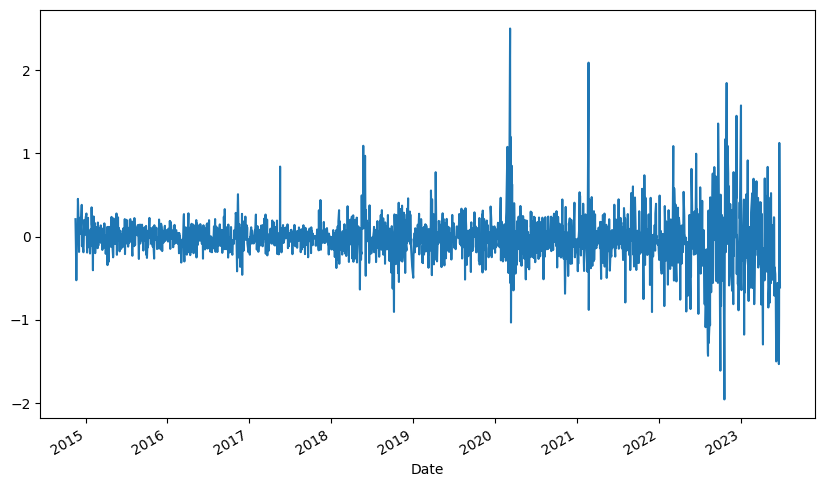

In [466]:
residual_plot(rf_only_one_lag_predictions, y_test)

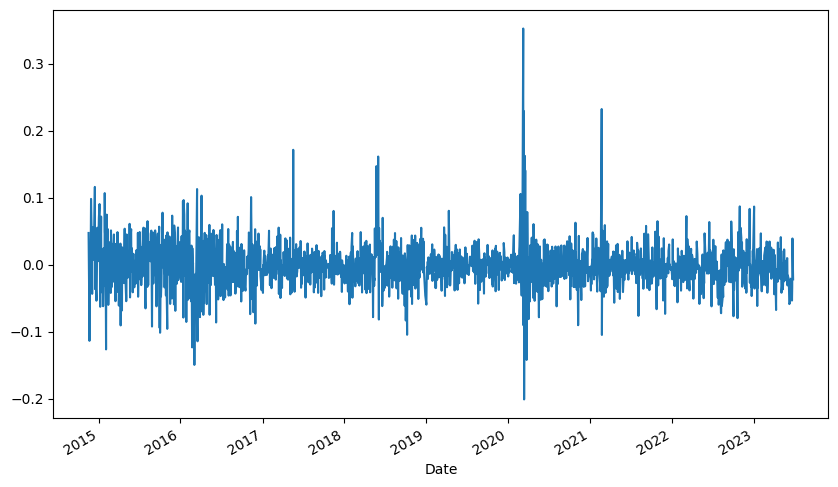

In [467]:
residual_log_plot(rf_only_one_lag_predictions, y_test)

### XGBoost with lags

#### Predictions

In [180]:
xgb_lag_predictions = one_step_ahead_forecasting(X = X, y = y, model = xgb, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [181]:
xgb_lag_predictions = pd.Series(xgb_lag_predictions, index = y_test.index)

#### Results

In [182]:
mean_squared_error(y_test, xgb_lag_predictions)

0.13285495080231446

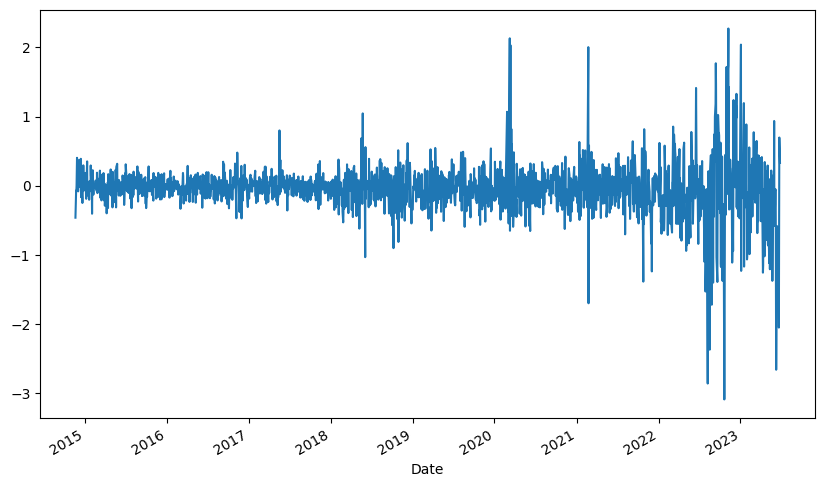

In [183]:
residual_plot(xgb_lag_predictions, y_test)

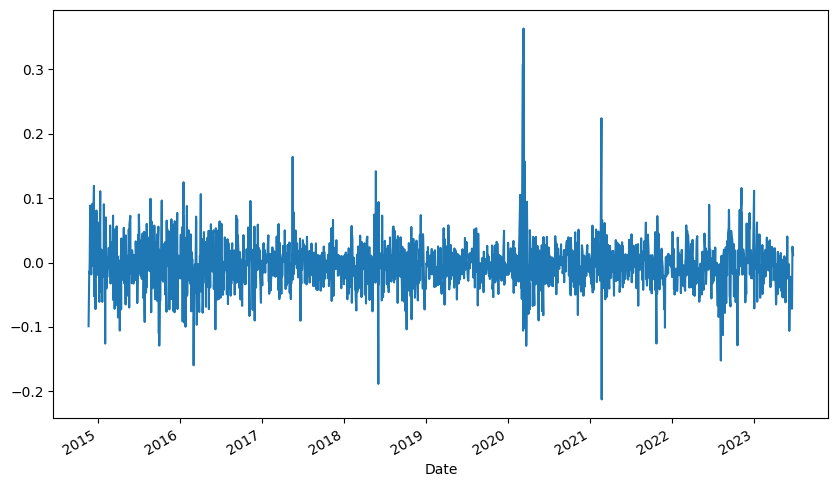

In [184]:
residual_log_plot(xgb_lag_predictions, y_test)

### XGBoost with only lags

#### Predictions

In [185]:
xgb_only_lag_predictions = one_step_ahead_forecasting(X = X_only_lag, y = y, 
                                                      model = xgb, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
P

In [186]:
xgb_only_lag_predictions = pd.Series(xgb_only_lag_predictions, index = y_test.index)

#### Results

In [187]:
mean_squared_error(y_test, xgb_only_lag_predictions)

0.15136874357855773

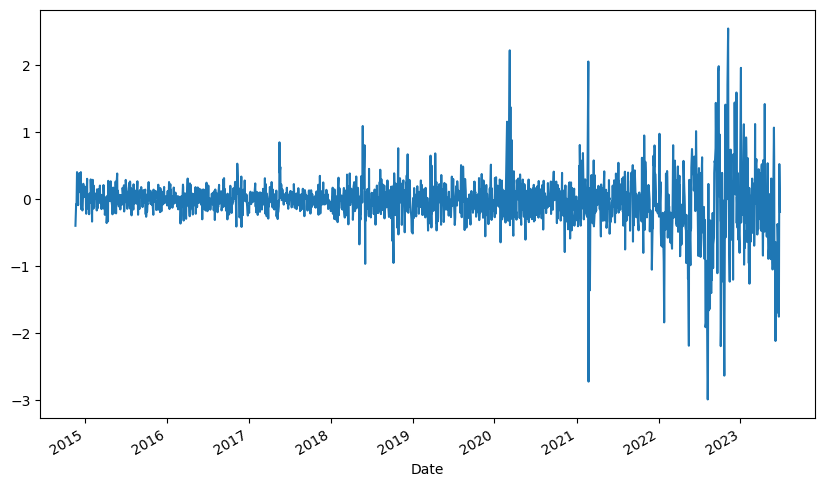

In [188]:
residual_plot(xgb_only_lag_predictions, y_test)

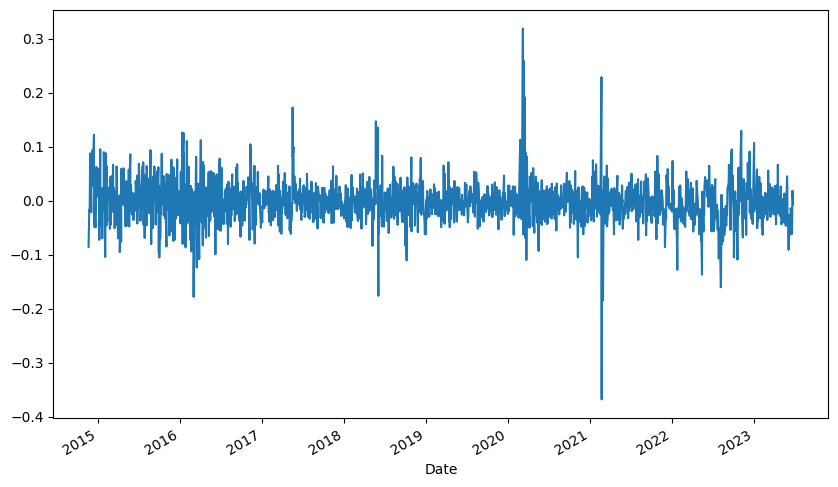

In [189]:
residual_log_plot(xgb_only_lag_predictions, y_test)

### XGBoost only one lag

#### Predictions

In [468]:
xgb_only_one_lag_predictions = one_step_ahead_forecasting_univariate(X = X_only_one_lag, y = y, 
                                                      model = xgb, starting_point = 0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [471]:
xgb_only_lag_predictions = pd.Series(xgb_only_lag_predictions, index = y_test.drop(y_test.index[0]).index)

#### Results

In [473]:
mean_squared_error(y_test.drop(y_test.index[0]), xgb_only_one_lag_predictions)

0.24658707558649762

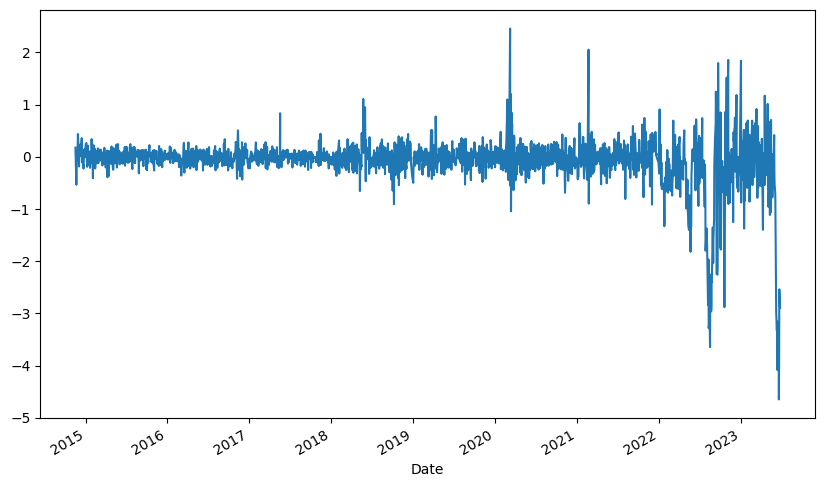

In [482]:
residual_plot(xgb_only_one_lag_predictions, y_test.drop(y_test.index[0]))

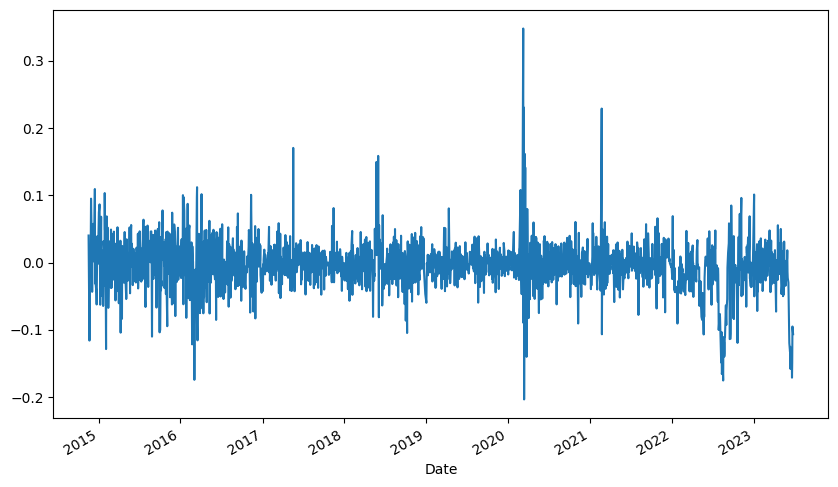

In [483]:
residual_log_plot(xgb_only_one_lag_predictions, y_test.drop(y_test.index[0]))

## Considering lags in the explanatory variables

We'll consider lags for the explanatory variables as well one lag for the response variable. We choose 5 lags for each variable and consider lags ranging from 1 to 20.

* Interest rate and exchange rate: lags from 20th to 15th day.

* Oil price: lags from 1st to 5th day.

### Getting back the original dataset

### Interest rate

In [191]:
selic = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/SELIC(2000-2023).csv")
selic = correct_data(selic, 'Data;Selic', ['Date', 'Selic'], ';')
selic = convert_datatypes(selic, column_to_numeric = 'Selic', column_to_date = 'Date')
selic = selic.loc[selic['Date'] >= start]

### Exchange rate

In [193]:
exchange_rate = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/Câmbio_diário(1984-2023)_v2.csv")
exchange_rate = correct_data(exchange_rate, 'Data;Cambio', ['Date', 'Exchange_rate'], ';')
exchange_rate = convert_datatypes(exchange_rate, column_to_numeric = 'Exchange_rate', column_to_date = 'Date')
exchange_rate = exchange_rate.loc[exchange_rate['Date'] >= start]

### Oil price

In [195]:
oil = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/petróleo_preço(1987-2023).csv")
oil = correct_data(oil, 'Data;Preço do petróleo brent(dólares/barril)', ['Date', 'Oil_price'], ';')
oil = convert_datatypes(oil, column_to_numeric = 'Oil_price', column_to_date = 'Date')
oil = oil.loc[oil['Date'] >= start]

### Stock price

In [196]:
stock = Ticker("PETR4.SA")
stock_price = stock.history(start = start, end = end)
stock_price = stock_price['adjclose']
stock_price = pd.DataFrame(stock_price, columns =['adjclose'])

stock_price = correct_multindex(stock_price, level=[0, 1], column_exclusion = 'symbol')
stock_price = convert_datatypes(stock_price, column_to_numeric = 'adjclose', column_to_date='date')
stock_price = stock_price.rename(columns={"date": "Date", "adjclose": "Close_price"})

### Merging all together

In [197]:
data_list = [stock_price, exchange_rate, selic, oil]

dataset = stock_price.merge(exchange_rate, on='Date')
dataset = dataset.merge(selic, on='Date')
dataset = dataset.merge(oil, on='Date')

dataset.index = dataset['Date']

dataset = dataset.drop('Date', axis=1)

### Adding lags

In [198]:
def add_lags(dataset, column, lags_list):
    '''add a specific set of lags for a temporal variable in a column of a dataset'''
    for i in lags_list:
        dataset[f'{column}_lag_{i}'] = dataset[column].shift(i)

In [199]:
add_lags(dataset = dataset, column = 'Selic', lags_list = [i for i in range(15, 21)])

In [200]:
add_lags(dataset = dataset, column = 'Exchange_rate', lags_list = [i for i in range(15, 21)])

In [201]:
add_lags(dataset = dataset, column = 'Oil_price', lags_list = [i for i in range(1, 6)])

In [202]:
dataset = dataset.dropna()

### Training test split 

In [203]:
y = dataset['Close_price']
X = dataset.drop('Close_price', axis = 1)

X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point=0.6)

### Models

### Regression tree

#### Predictions

In [204]:
tree_X_lag_predictions = one_step_ahead_forecasting(X = X, y = y, model = reg_tree ,starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
P

In [205]:
tree_X_lag_predictions = pd.Series(tree_X_lag_predictions, index = y_test.index)

#### Results

In [206]:
mean_squared_error(y_test, tree_X_lag_predictions)

0.6991310250490467

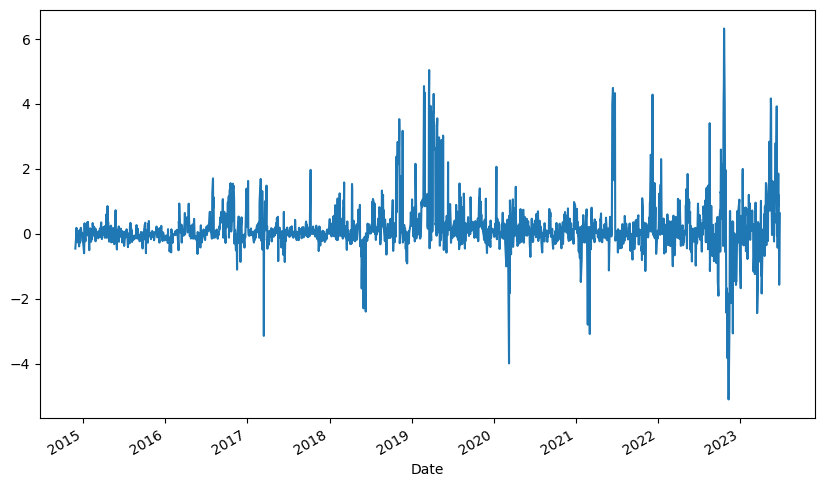

In [207]:
residual_plot(y_test, tree_X_lag_predictions)

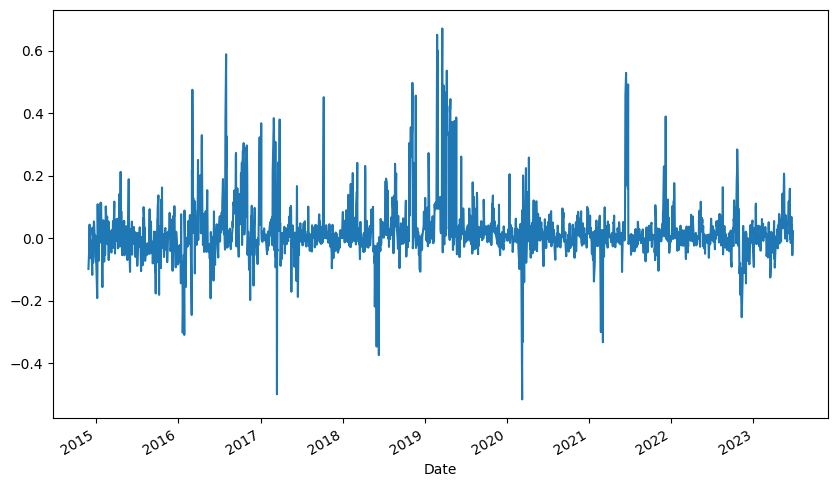

In [208]:
residual_log_plot(y_test, tree_X_lag_predictions)

### Random forest

#### Predictions

In [209]:
rf_X_lag_predictions = one_step_ahead_forecasting(X = X, y = y, model = rf_reg ,starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [210]:
rf_X_lag_predictions = pd.Series(rf_X_lag_predictions, index = y_test.index)

#### Results

In [211]:
mean_squared_error(y_test, rf_X_lag_predictions)

0.4607763370489489

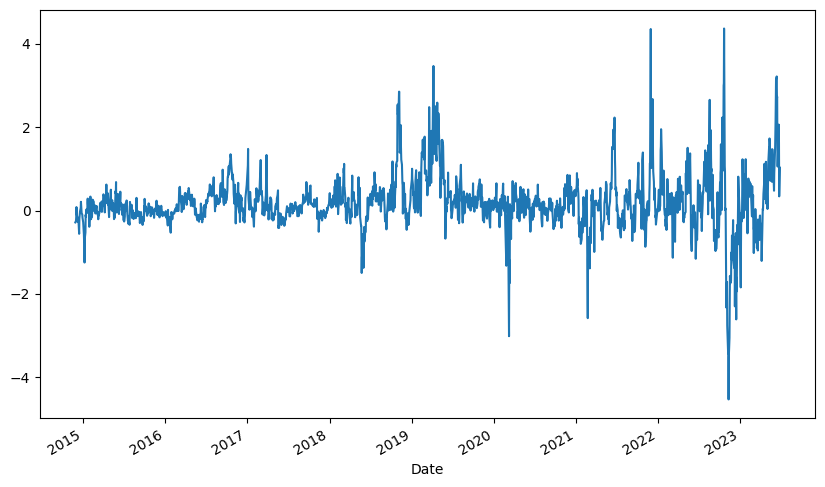

In [212]:
residual_plot(y_test, rf_X_lag_predictions)

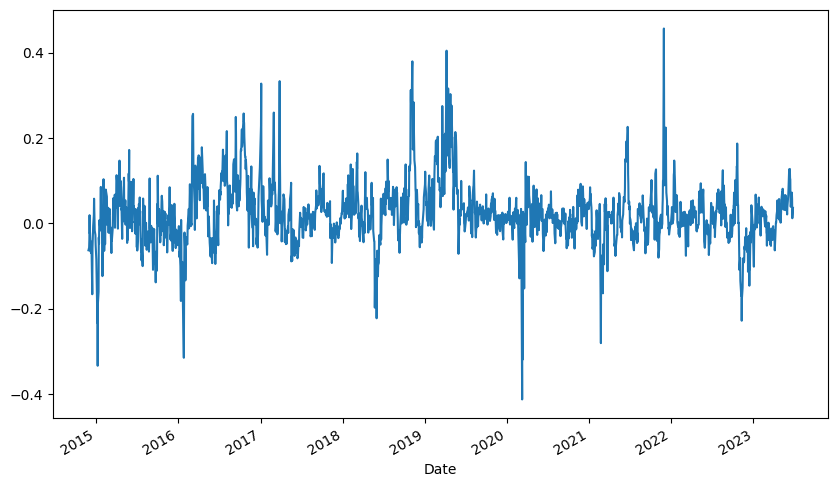

In [213]:
residual_log_plot(y_test, rf_X_lag_predictions)

### XGBoost

#### Predictions

In [214]:
xgb_X_lag_predictions = one_step_ahead_forecasting(X = X, y = y, model = xgb, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [215]:
xgb_X_lag_predictions = pd.Series(xgb_X_lag_predictions, index = y_test.index)

#### Results

In [216]:
mean_squared_error(y_test, xgb_X_lag_predictions)

0.4787791256578415

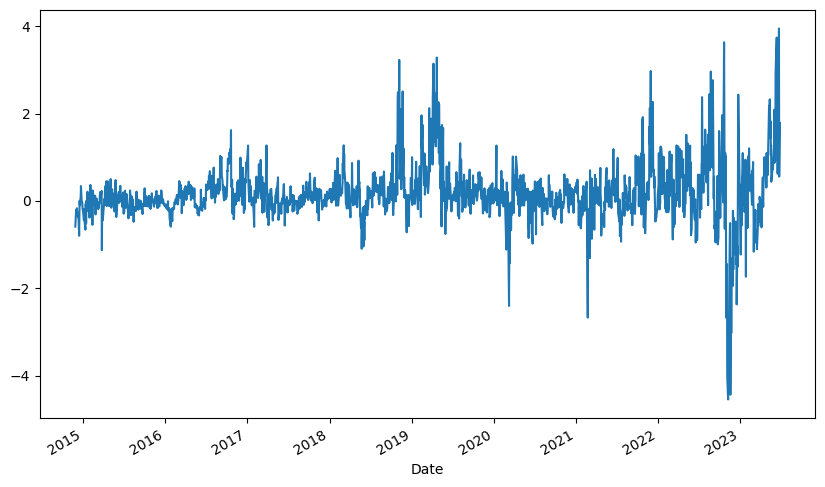

In [217]:
residual_plot(y_test, xgb_X_lag_predictions)

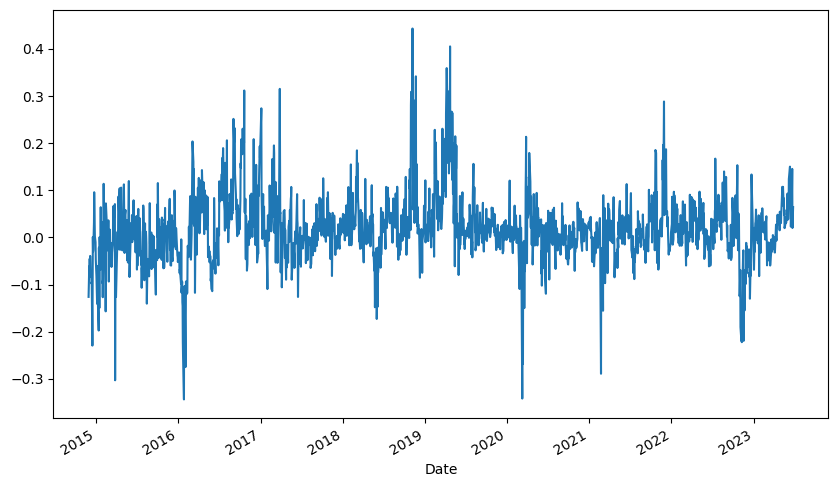

In [218]:
residual_log_plot(y_test, xgb_X_lag_predictions)

### Adding one lag for the response variable

Besides the lags used in the explanatory variables, we'll add a one day lag for the response variable.

In [219]:
add_lags(dataset = dataset, column = 'Close_price', lags_list = [1])

In [220]:
dataset = dataset.dropna()

### Training test split

In [221]:
y = dataset['Close_price']
X = dataset.drop('Close_price', axis = 1)

X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point=0.6)

### Models

### Regression Tree

#### Predictions

In [222]:
tree_features_lag_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = reg_tree ,starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [223]:
tree_features_lag_predictions = pd.Series(tree_features_lag_predictions, index = y_test.index)

#### Results

In [224]:
mean_squared_error(y_test, tree_features_lag_predictions)

0.15604402284326305

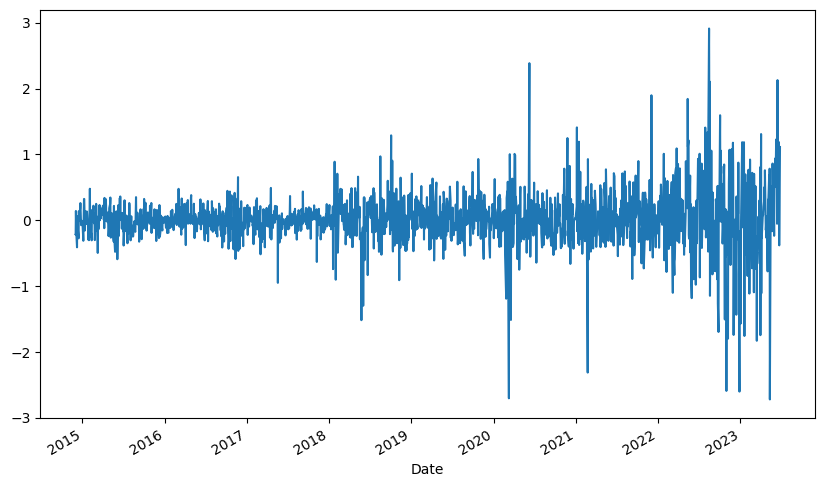

In [225]:
residual_plot(y_test, tree_features_lag_predictions)

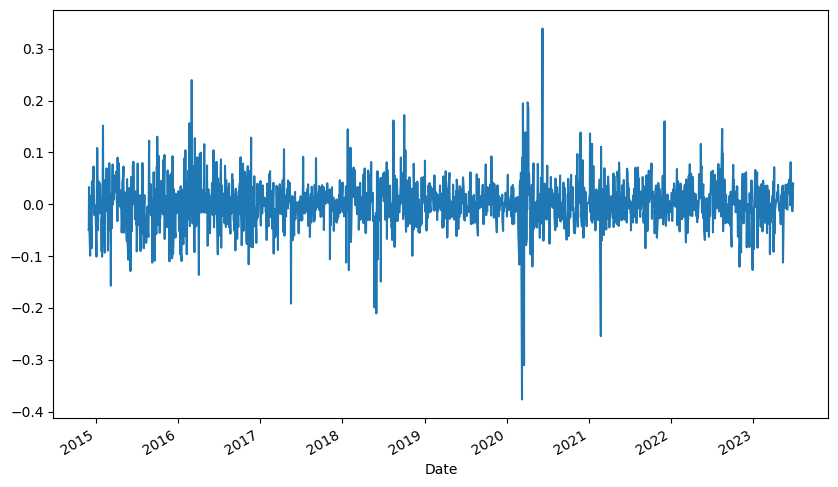

In [226]:
residual_log_plot(y_test, tree_features_lag_predictions)

### Random Forest

#### Predictions

In [227]:
rf_features_lag_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = rf_reg ,starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
P

In [228]:
rf_features_lag_predictions = pd.Series(rf_features_lag_predictions, index = y_test.index)

#### Results

In [229]:
mean_squared_error(y_test, rf_features_lag_predictions)

0.11431106517892162

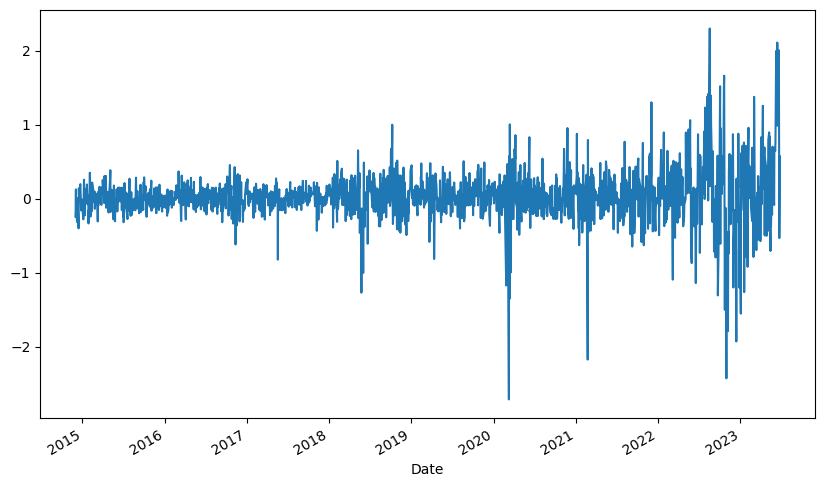

In [230]:
residual_plot(y_test, rf_features_lag_predictions)

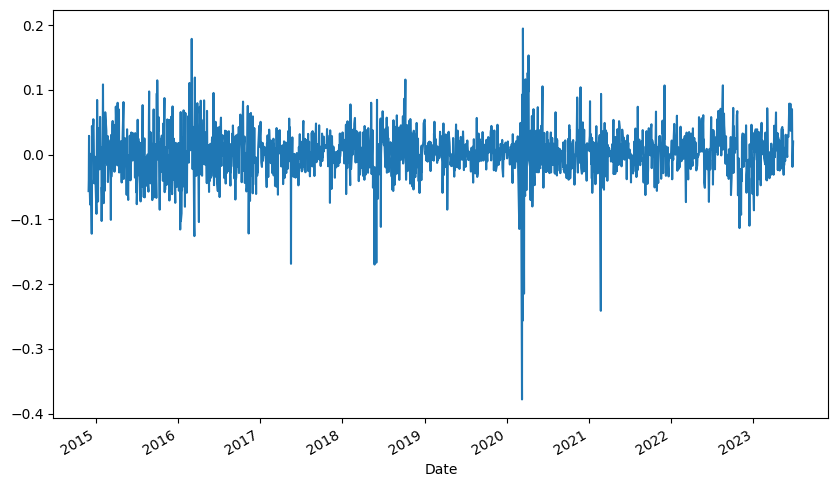

In [231]:
residual_log_plot(y_test, rf_features_lag_predictions)

### XGBoost

#### Predictions

In [232]:
xgb_features_lag_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = xgb, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
P

In [233]:
xgb_features_lag_predictions = pd.Series(xgb_features_lag_predictions, index = y_test.index)

#### Results

In [234]:
mean_squared_error(y_test, xgb_features_lag_predictions)

0.15252235581760326

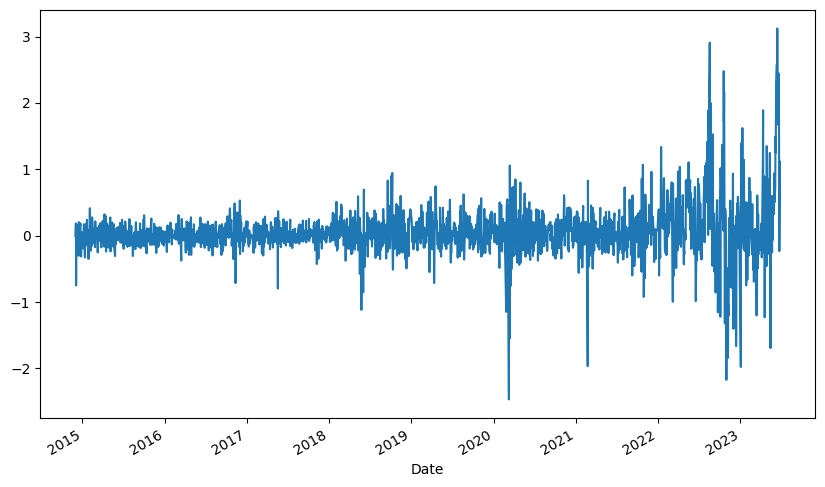

In [235]:
residual_plot(y_test, xgb_features_lag_predictions)

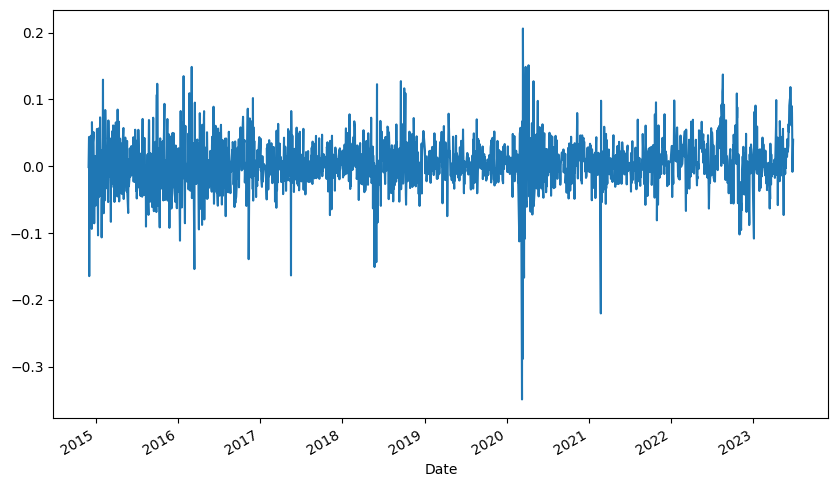

In [236]:
residual_log_plot(y_test, xgb_features_lag_predictions)

### Considering stationary variables

Now, we'll apply stationarity for the variables of the dataset. We'll consider the following settings: 

* Only stationary response variable

* Explanatoy and response variables as stationaries.

* Explanatory and response variables stationaries, with lags for the explanatory variables

* Explanatory and response variables stationaries, wtih lags for the explanatory variables and a lag for the response variable

### Getting back the original dataset

### Interest Rate (SELIC)

In [237]:
selic = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/SELIC(2000-2023).csv")
selic = correct_data(selic, 'Data;Selic', ['Date', 'Selic'], ';')
selic = convert_datatypes(selic, column_to_numeric = 'Selic', column_to_date = 'Date')
selic = selic.loc[selic['Date'] >= start]

### Exchange Rate

In [240]:
exchange_rate = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/Câmbio_diário(1984-2023)_v2.csv")
exchange_rate = correct_data(exchange_rate, 'Data;Cambio', ['Date', 'Exchange_rate'], ';')
exchange_rate = convert_datatypes(exchange_rate, column_to_numeric = 'Exchange_rate', column_to_date = 'Date')
exchange_rate = exchange_rate.loc[exchange_rate['Date'] >= start]

### Oil price

In [242]:
oil = open_data(r"/home/caio/Documentos/Petrobras S.A/Dados_input/petróleo_preço(1987-2023).csv")
oil = correct_data(oil, 'Data;Preço do petróleo brent(dólares/barril)', ['Date', 'Oil_price'], ';')
oil = convert_datatypes(oil, column_to_numeric = 'Oil_price', column_to_date = 'Date')
oil = oil.loc[oil['Date'] >= start]

### Stock Price

In [243]:
stock = Ticker("PETR4.SA")
stock_price = stock.history(start = start, end = end)
stock_price = stock_price['adjclose']
stock_price = pd.DataFrame(stock_price, columns =['adjclose'])

stock_price = correct_multindex(stock_price, level=[0, 1], column_exclusion = 'symbol')
stock_price = convert_datatypes(stock_price, column_to_numeric = 'adjclose', column_to_date='date')
stock_price = stock_price.rename(columns={"date": "Date", "adjclose": "Close_price"})

### Merging all together

In [244]:
data_list = [stock_price, exchange_rate, selic, oil]

dataset = stock_price.merge(exchange_rate, on='Date')
dataset = dataset.merge(selic, on='Date')
dataset = dataset.merge(oil, on='Date')

dataset.index = dataset['Date']

dataset = dataset.drop('Date', axis=1)

### Applying stationarity for the response variable

In [245]:
y_stationary = np.diff(dataset['Close_price'], n = 1)

In [246]:
dataset_y_stationary = dataset.drop(dataset.index[0])

In [247]:
y_stationary = pd.Series(y_stationary, index = dataset_y_stationary.index, 
                        name = 'Close_price_stationary')

In [248]:
dataset_y_stationary

Close_price  Exchange_rate  Selic  Oil_price
Date                                                    
2002-01-02     1.581756          2.306  19.00      20.13
2002-01-03     1.592558          2.292  19.00      20.47
2002-01-04     1.582682          2.309  19.00      21.20
2002-01-07     1.617249          2.342  19.00      21.08
2002-01-08     1.597188          2.345  19.00      21.03
...                 ...            ...    ...        ...
2023-06-20    28.357920          4.792  13.75      75.79
2023-06-21    29.545300          4.779  13.75      76.92
2023-06-22    29.174244          4.774  13.75      73.93
2023-06-23    27.977589          4.779  13.75      73.56
2023-06-26    28.608385          4.769  13.75      73.86

[5238 rows x 4 columns]

In [254]:
dataset_y_stationary = dataset_y_stationary.join(y_stationary)

In [255]:
dataset_y_stationary

Close_price  Exchange_rate  Selic  Oil_price  \
Date                                                       
2002-01-02     1.581756          2.306  19.00      20.13   
2002-01-03     1.592558          2.292  19.00      20.47   
2002-01-04     1.582682          2.309  19.00      21.20   
2002-01-07     1.617249          2.342  19.00      21.08   
2002-01-08     1.597188          2.345  19.00      21.03   
...                 ...            ...    ...        ...   
2023-06-20    28.357920          4.792  13.75      75.79   
2023-06-21    29.545300          4.779  13.75      76.92   
2023-06-22    29.174244          4.774  13.75      73.93   
2023-06-23    27.977589          4.779  13.75      73.56   
2023-06-26    28.608385          4.769  13.75      73.86   

            Close_price_stationary  
Date                                
2002-01-02                0.003086  
2002-01-03                0.010802  
2002-01-04               -0.009877  
2002-01-07                0.034567  
2002-01-08               -0.020061  
...                            ...  
2023-06-20                0.139145  
2023-06-21                1.187380  
2023-06-22               -0.371056  
2023-06-23               -1.196655  
2023-06-26                0.630796  

[5238 rows x 5 columns]

In [256]:
dataset_y_stationary = dataset_y_stationary.drop('Close_price', axis = 1) 

### Training test split

In [257]:
y = dataset_y_stationary['Close_price_stationary']
X = dataset_y_stationary.drop('Close_price_stationary', axis = 1)

In [258]:
X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point=0.6)

### Regression Tree with stationary response variable

#### Predictions

In [259]:
tree_y_stationary_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = reg_tree, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
P

In [260]:
tree_y_stationary_predictions = pd.Series(tree_y_stationary_predictions, index = y_test.index)

#### Results

In [261]:
mean_squared_error(y_test, tree_y_stationary_predictions)

0.17372531702451474

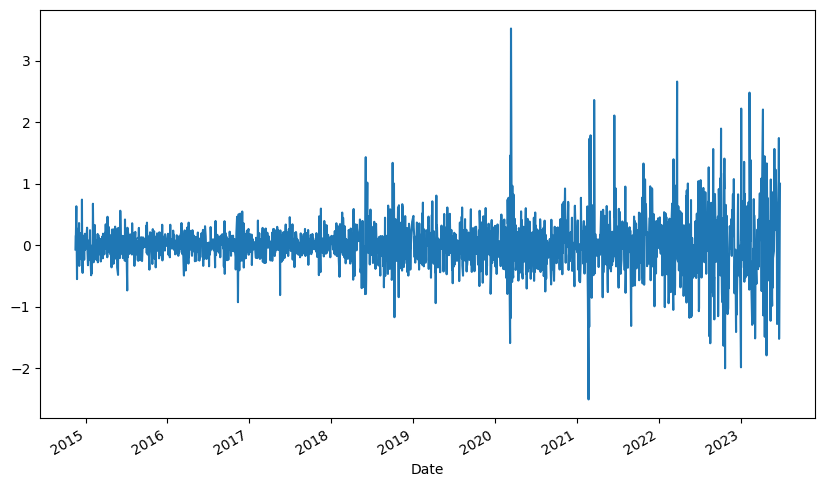

In [262]:
residual_plot(y_test, tree_y_stationary_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


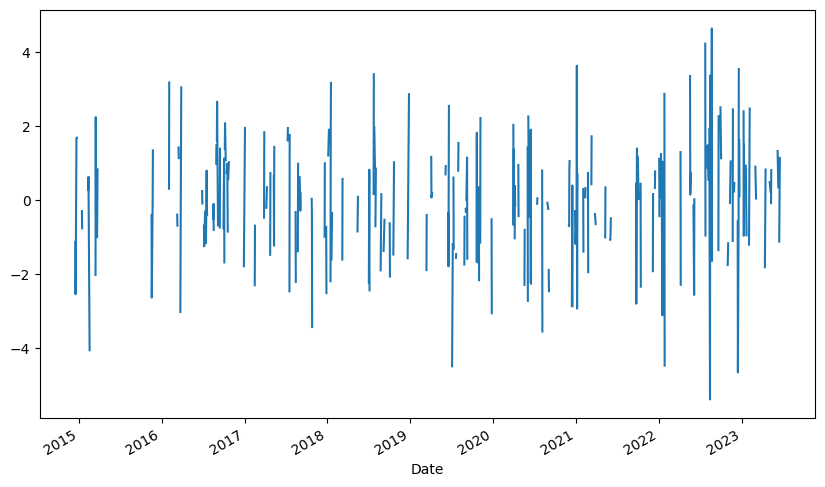

In [263]:
residual_log_plot(y_test, tree_y_stationary_predictions)

### Random Forest with stationary response variable

#### Predictions

In [264]:
rf_y_stationary_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = rf_reg, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [265]:
rf_y_stationary_predictions = pd.Series(rf_y_stationary_predictions, index = y_test.index)

#### Results

In [266]:
mean_squared_error(y_test, rf_y_stationary_predictions)

0.089648235538796

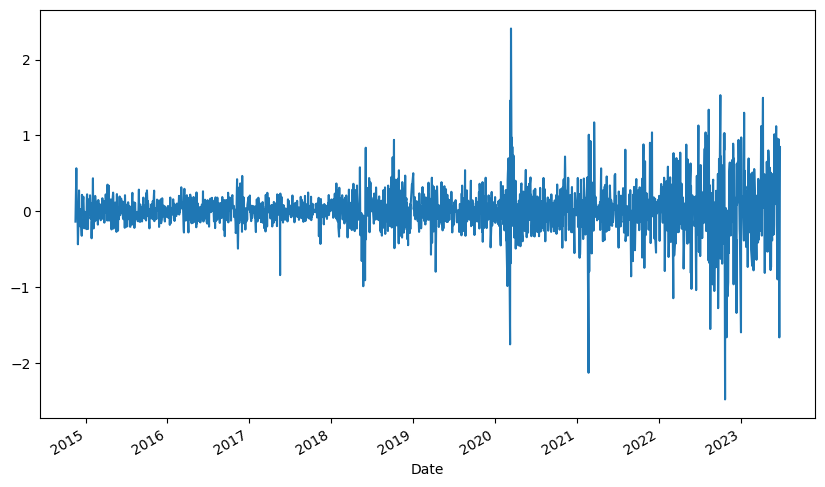

In [267]:
residual_plot(y_test, rf_y_stationary_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


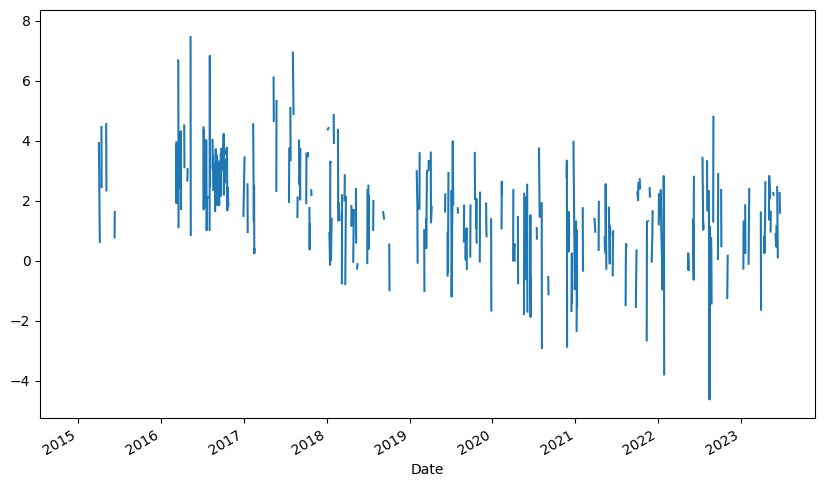

In [268]:
residual_log_plot(y_test, rf_y_stationary_predictions)

### XGBoost with stationary response variable

#### Predictions

In [269]:
xgb_y_stationary_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = xgb, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [270]:
xgb_y_stationary_predictions = pd.Series(xgb_y_stationary_predictions, index = y_test.index)

#### Results

In [271]:
mean_squared_error(y_test, xgb_y_stationary_predictions)

0.1192769679046921

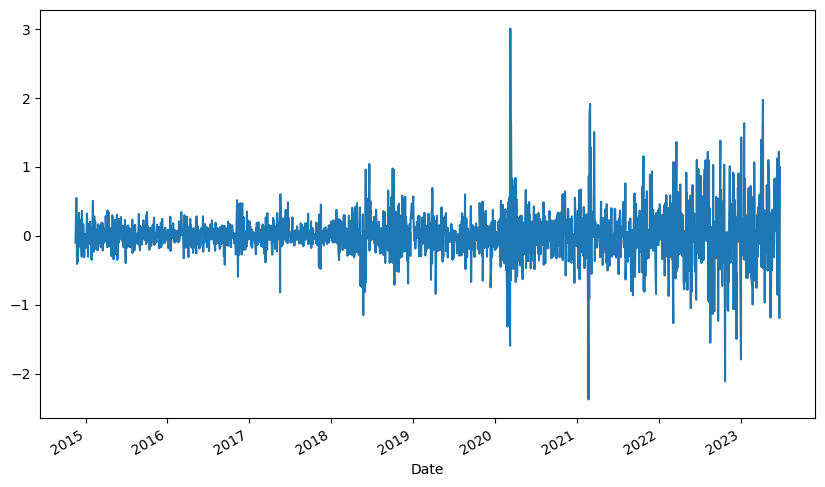

In [272]:
residual_plot(y_test, xgb_y_stationary_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


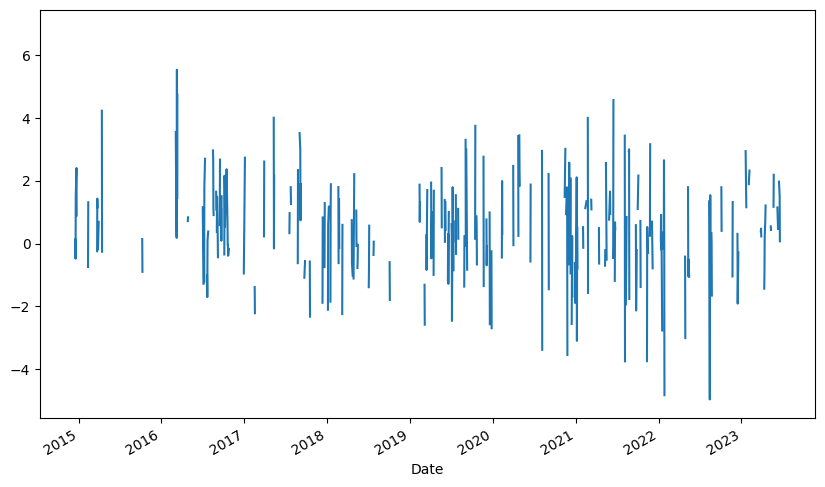

In [273]:
residual_log_plot(y_test, xgb_y_stationary_predictions)

### Applying stationarity into the explanatory variables

In [274]:
selic_stationary = np.diff(dataset['Selic'], n = 1)

exchange_rate_stationary = np.diff(dataset['Exchange_rate'], n = 1)

oil_stationary = np.diff(dataset['Exchange_rate'], n = 1)

In [275]:
dataset_stationary = dataset.drop(dataset.index[0])

In [276]:
dataset_stationary = pd.DataFrame({'Selic_stationary': selic_stationary,
                                   'Exchange_rate_stationary': exchange_rate_stationary,
                                  'Oil_stationary': oil_stationary, 
                                  'Close_price_stationary': y_stationary},
                                  index = dataset_stationary.index)

### Training test split

In [277]:
y = dataset_stationary['Close_price_stationary']

X = dataset_stationary.drop('Close_price_stationary', axis = 1)

In [278]:
X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point=0.6)

### Regression Tree with stationarity for all the variables

#### Predictions

In [279]:
tree_stationary_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = reg_tree, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [280]:
tree_stationary_predictions = pd.Series(tree_stationary_predictions, index = y_test.index)

#### Results

In [281]:
mean_squared_error(y_test, tree_stationary_predictions)

0.07993046952893908

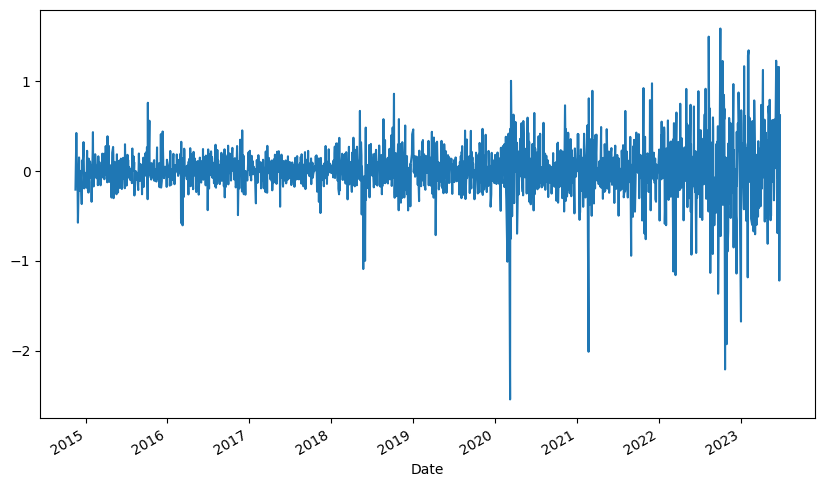

In [282]:
residual_plot(y_test, tree_stationary_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


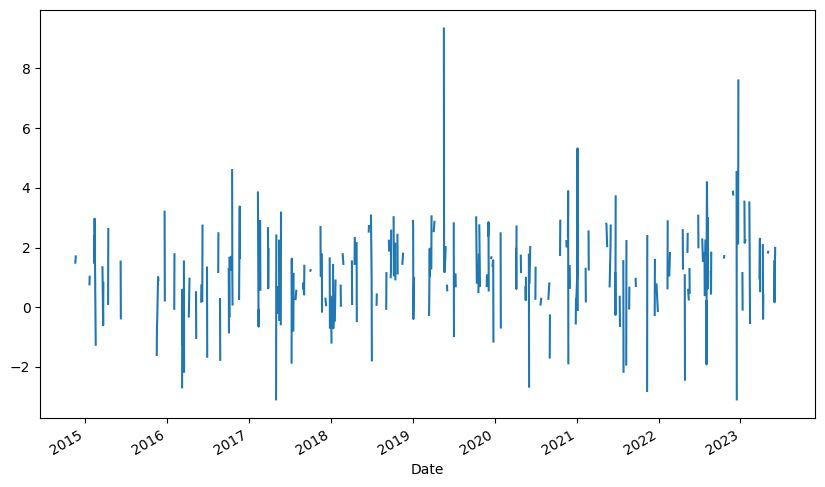

In [283]:
residual_log_plot(y_test, tree_stationary_predictions)

### Random Forest with stationarity for all the variables

#### Predictions

In [284]:
rf_stationary_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = rf_reg, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [285]:
rf_stationary_predictions = pd.Series(rf_stationary_predictions, index = y_test.index)

#### Results

In [286]:
mean_squared_error(y_test, rf_stationary_predictions)

0.07572638578961442

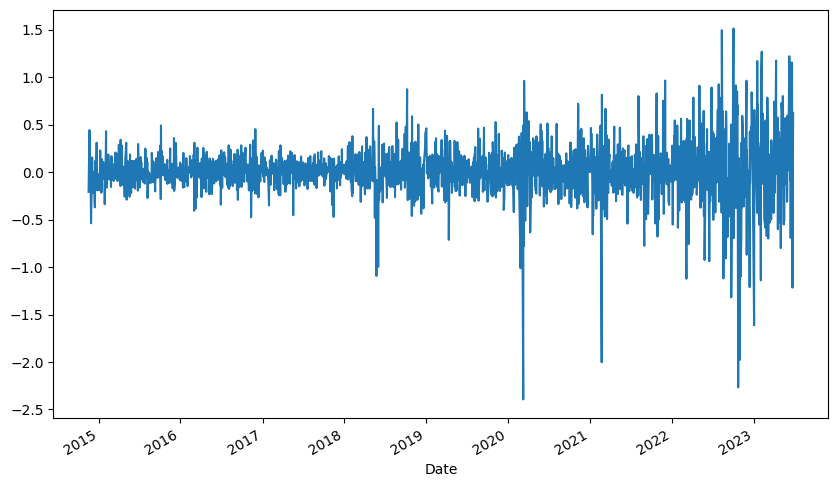

In [287]:
residual_plot(y_test, rf_stationary_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


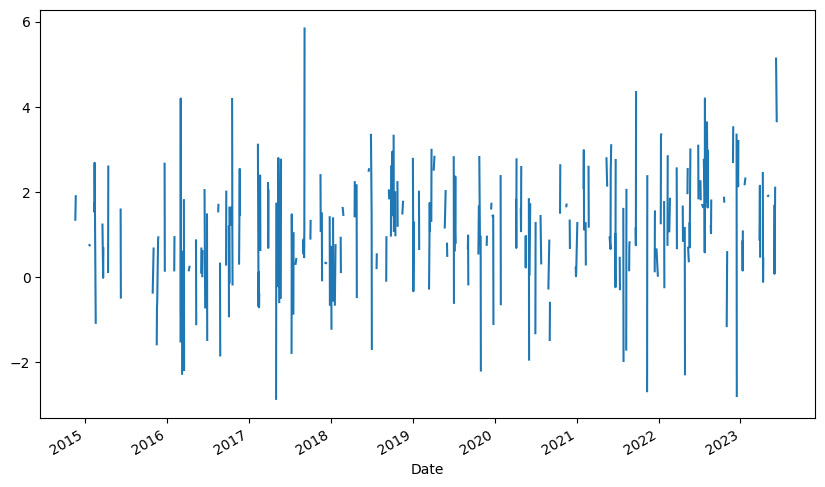

In [288]:
residual_log_plot(y_test, rf_stationary_predictions)

### XGBoost with stationarity for all the variables

#### Predictions

In [289]:
xgb_stationary_predictions = one_step_ahead_forecasting(X = X, y = y, model = xgb, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [290]:
xgb_stationary_predictions = pd.Series(xgb_stationary_predictions, index = y_test.index)

#### Results

In [291]:
mean_squared_error(y_test, xgb_stationary_predictions)

0.07629692855419726

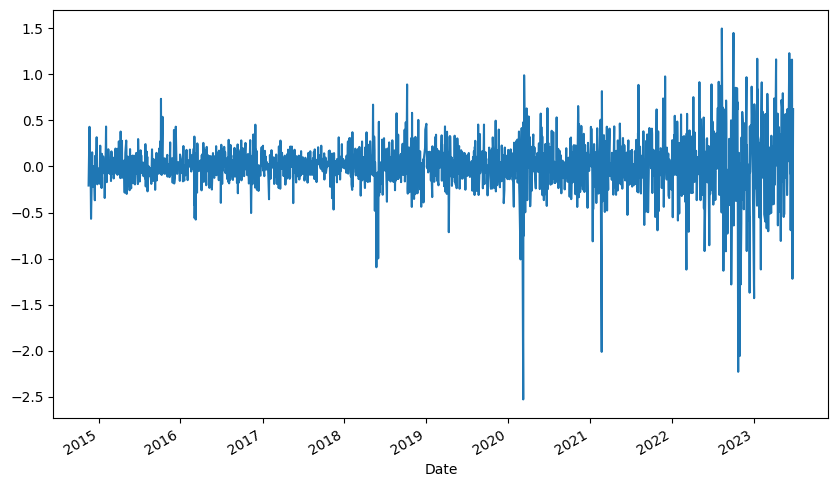

In [292]:
residual_plot(y_test, xgb_stationary_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


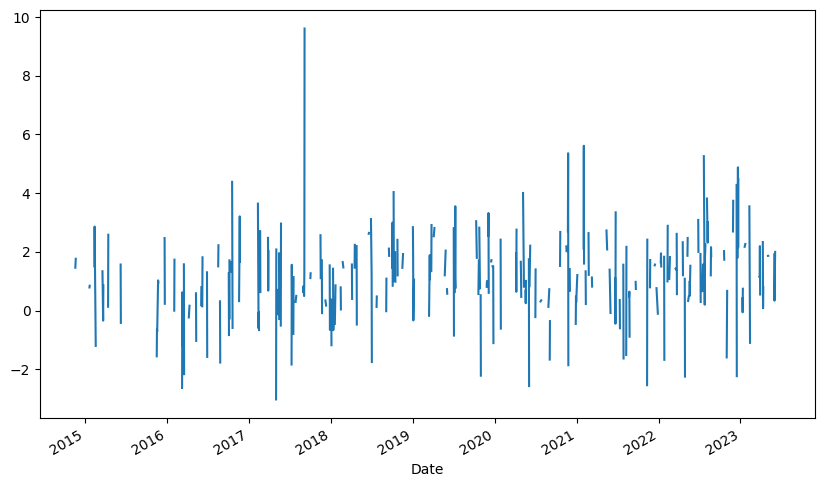

In [293]:
residual_log_plot(y_test, xgb_stationary_predictions)

### Explanatory and response variables stationaries, with lags for the explanatory variables


In [294]:
add_lags(dataset = dataset_stationary, column = 'Selic_stationary', lags_list = [i for i in range(15, 21)])

In [296]:
add_lags(dataset = dataset_stationary, column = 'Exchange_rate_stationary', lags_list = [i for i in range(15, 21)])

In [297]:
add_lags(dataset = dataset_stationary, column = 'Oil_stationary', lags_list = [i for i in range(1, 6)])

In [298]:
dataset_stationary = dataset_stationary.dropna()

### Training test split

In [299]:
y = dataset_stationary['Close_price_stationary']

X = dataset_stationary.drop('Close_price_stationary', axis = 1)

In [300]:
X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point=0.6)

### Regression Tree with explanatory and response variables stationaries, and with lags for the explanatory variables 

#### Predictions

In [301]:
tree_stationary_lag_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = reg_tree, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [302]:
tree_stationary_lag_predictions = pd.Series(tree_stationary_lag_predictions, index = y_test.index)

#### Results

In [303]:
mean_squared_error(y_test, tree_stationary_lag_predictions)

0.12274306341044726

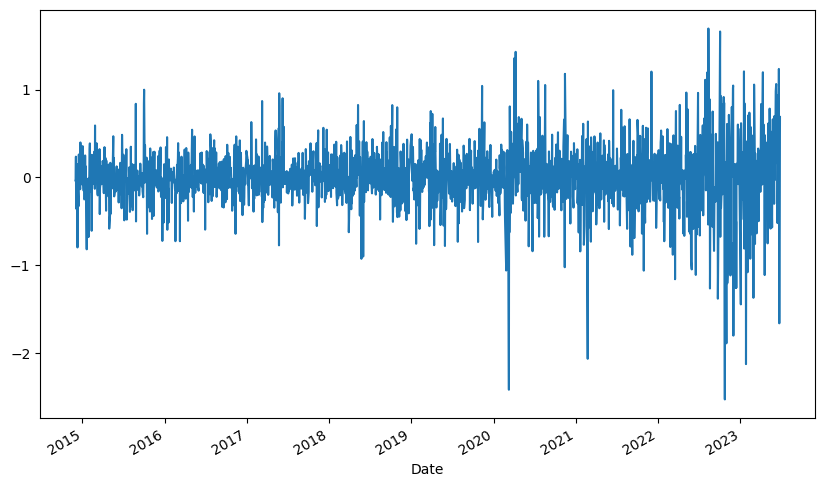

In [304]:
residual_plot(y_test, tree_stationary_lag_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


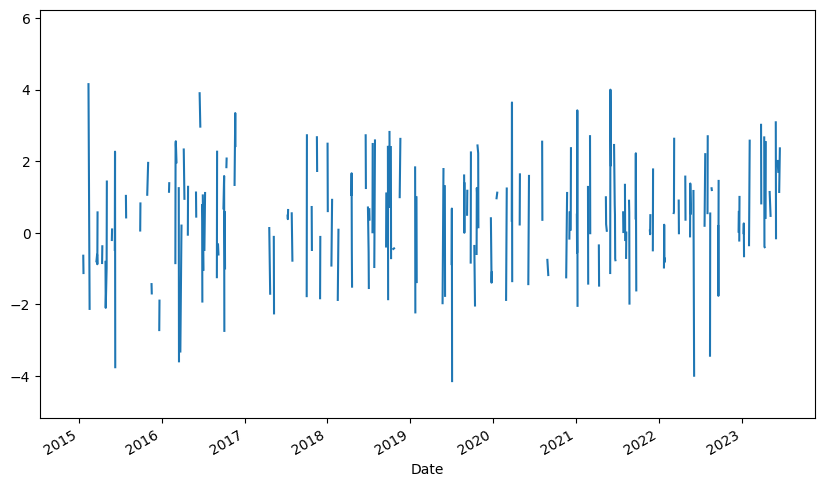

In [305]:
residual_log_plot(y_test, tree_stationary_lag_predictions)

### Random Forest with explanatory and response variables stationaries, and with lags for the explanatory variables

#### Predictions

In [306]:
rf_stationary_lag_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = rf_reg, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [307]:
rf_stationary_lag_predictions = pd.Series(rf_stationary_lag_predictions, index = y_test.index)

#### Results

In [308]:
mean_squared_error(y_test, rf_stationary_lag_predictions)

0.07484765554224548

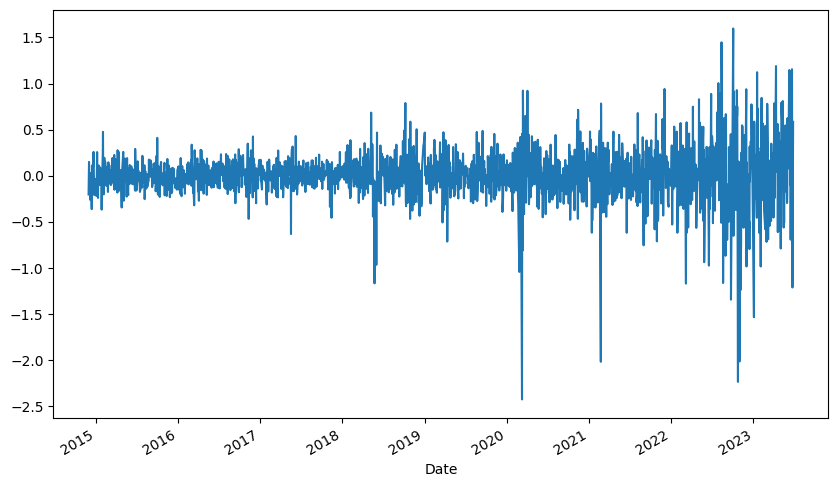

In [309]:
residual_plot(y_test, rf_stationary_lag_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


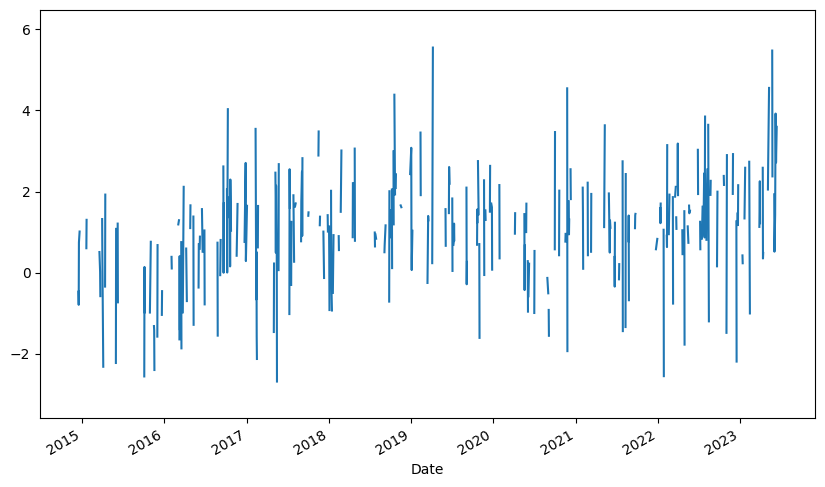

In [310]:
residual_log_plot(y_test, rf_stationary_lag_predictions)

### XGBoost with explanatory and response variables stationaries, and with lags for the explanatory variables

#### Predictions

In [311]:
xgb_stationary_lag_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = xgb, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [312]:
xgb_stationary_lag_predictions = pd.Series(xgb_stationary_lag_predictions, index = y_test.index)

#### Results

In [313]:
mean_squared_error(y_test, xgb_stationary_lag_predictions)

0.08022984687971553

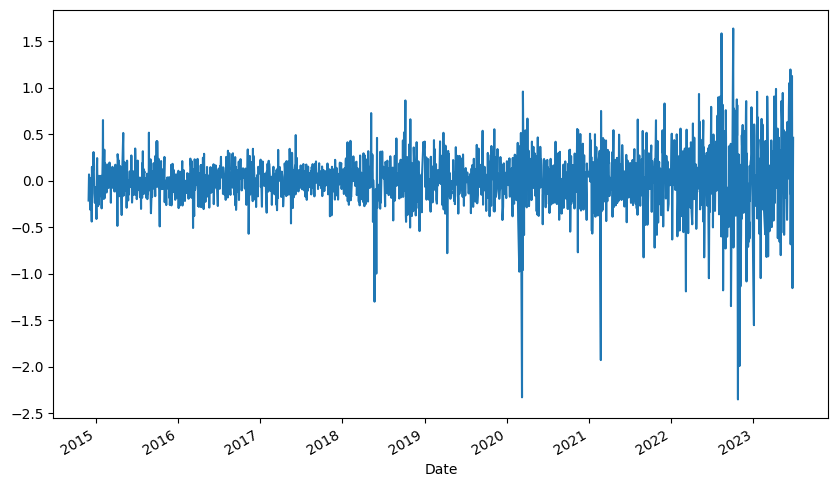

In [314]:
residual_plot(y_test, xgb_stationary_lag_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


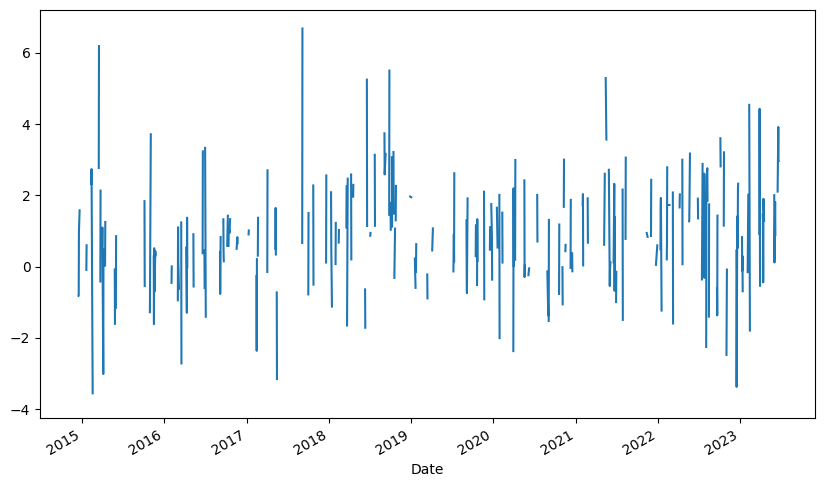

In [315]:
residual_log_plot(y_test, xgb_stationary_lag_predictions)

### Adding a lag for the response variable

In [318]:
dataset_stationary.columns

Index(['Selic_stationary', 'Exchange_rate_stationary', 'Oil_stationary',
       'Close_price_stationary', 'Selic_stationary_lag_15',
       'Selic_stationary_lag_16', 'Selic_stationary_lag_17',
       'Selic_stationary_lag_18', 'Selic_stationary_lag_19',
       'Selic_stationary_lag_20', 'Exchange_rate_stationary_lag_15',
       'Exchange_rate_stationary_lag_16', 'Exchange_rate_stationary_lag_17',
       'Exchange_rate_stationary_lag_18', 'Exchange_rate_stationary_lag_19',
       'Exchange_rate_stationary_lag_20', 'Oil_stationary_lag_1',
       'Oil_stationary_lag_2', 'Oil_stationary_lag_3', 'Oil_stationary_lag_4',
       'Oil_stationary_lag_5'],
      dtype='object')

In [319]:
add_lags(dataset = dataset_stationary, column = 'Close_price_stationary', lags_list = [1])

/tmp/ipykernel_89850/1298006303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'{column}_lag_{i}'] = dataset[column].shift(i)


In [320]:
dataset_stationary = dataset_stationary.dropna()

### Training test split

In [321]:
y = dataset_stationary['Close_price_stationary']

X = dataset_stationary.drop('Close_price_stationary', axis = 1)

In [322]:
X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point=0.6)

### Regression Tree with explanatory and response variables stationaries, and with lags for all the variables

#### Predictions

In [323]:
tree_stationary_lag_y_predictions = one_step_ahead_forecasting(X = X,
                                                           y = y, model = reg_tree, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [324]:
tree_stationary_lag_y_predictions = pd.Series(tree_stationary_lag_predictions, index = y_test.index)

#### Results

In [325]:
mean_squared_error(y_test, tree_stationary_lag_y_predictions)

0.12274306341044726

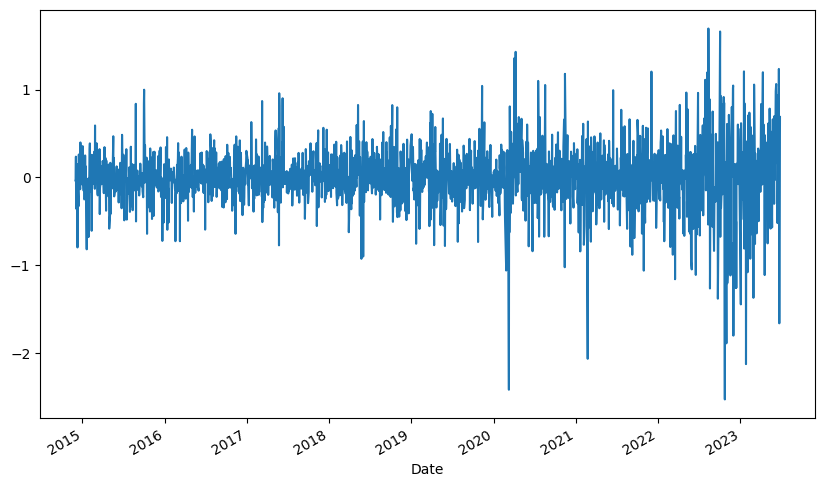

In [326]:
residual_plot(y_test, tree_stationary_lag_y_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


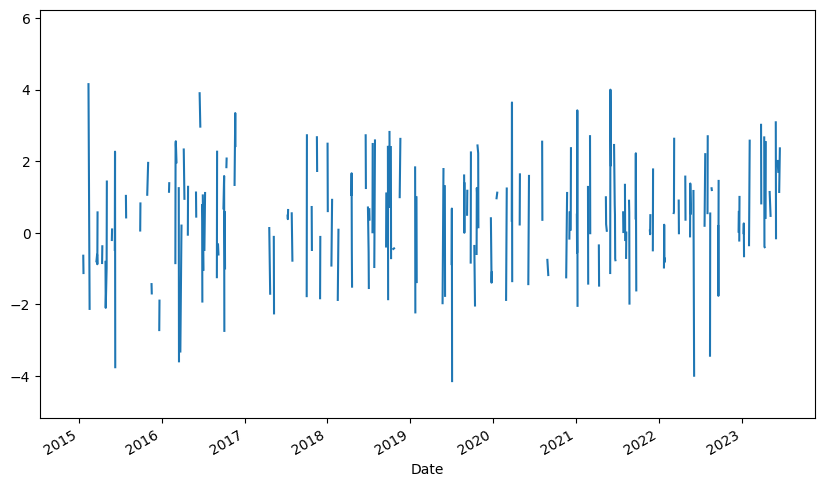

In [327]:
residual_log_plot(y_test, tree_stationary_lag_y_predictions)

### Random Forest with explanatory and response variables stationaries, and with lags for all the variables

#### Predictions

In [328]:
rf_stationary_lag_y_predictions = one_step_ahead_forecasting(X = X, y = y,
                                                             model = rf_reg, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [329]:
rf_stationary_lag_y_predictions = pd.Series(rf_stationary_lag_y_predictions, index = y_test.index)

#### Results

In [330]:
mean_squared_error(y_test, rf_stationary_lag_y_predictions)

0.07729847660135537

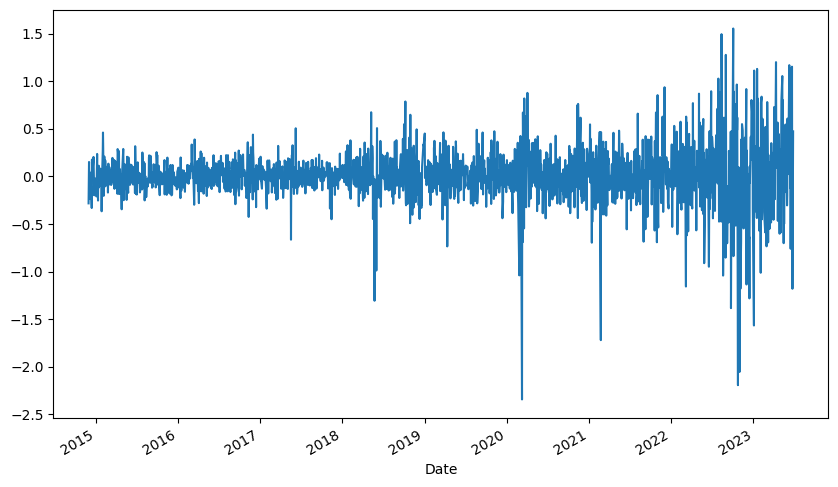

In [331]:
residual_plot(y_test, rf_stationary_lag_y_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


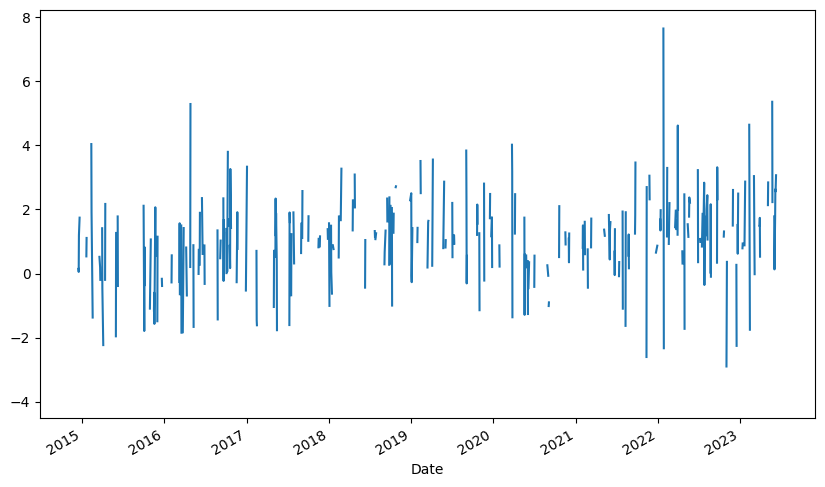

In [332]:
residual_log_plot(y_test, rf_stationary_lag_y_predictions)

### XGBoost with explanatory and response variables stationaries, and with lags for  all the variables

#### Predictions

In [333]:
xgb_stationary_lag_y_predictions = one_step_ahead_forecasting(X = X, y = y,
                                                             model = xgb, starting_point=0.6)

Treinando
Fit
Fit final
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Predição
Pred

In [334]:
xgb_stationary_lag_y_predictions = pd.Series(xgb_stationary_lag_y_predictions, index = y_test.index)

#### Results

In [335]:
mean_squared_error(y_test, xgb_stationary_lag_y_predictions)

0.08798372121943829

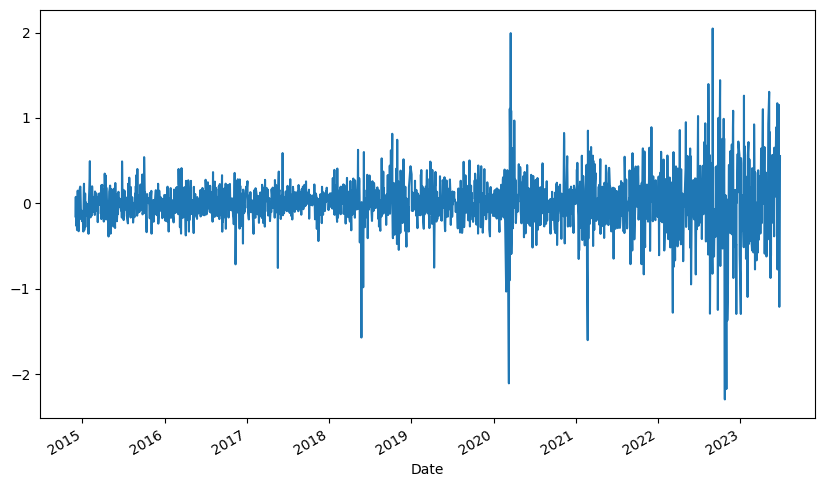

In [336]:
residual_plot(y_test, xgb_stationary_lag_y_predictions)

/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/caio/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


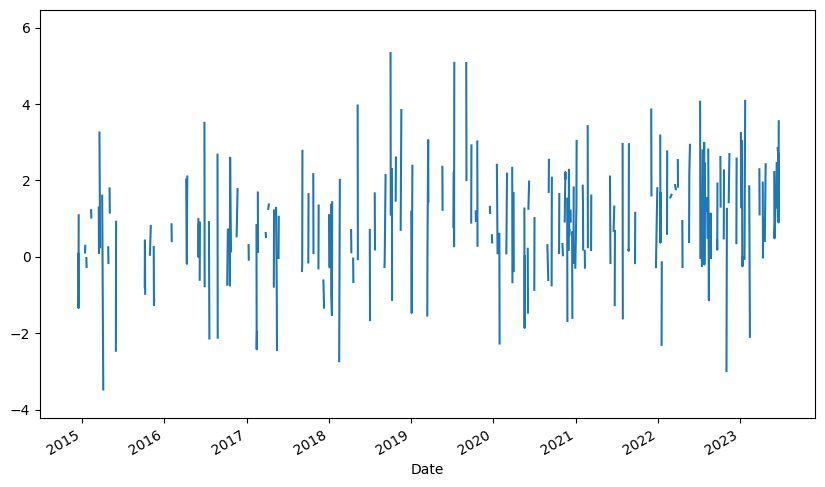

In [337]:
residual_log_plot(y_test, xgb_stationary_lag_y_predictions)